<a href="https://colab.research.google.com/github/andrewpwalters/panel_data/blob/main/panel_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Panel data econometrics homework

##Andrew Walters

In this paper we will complete the problemset using the dataset from ’Aid, Policies, and Growth’ (Burnside & Dollar 2000). Portions of our Python code and methodology are adapted from Grabowski’s replication of their paper utilizing the same dataset (Grabowski 2020). For our dataset we will use the cleaned version provided by Dr. Chatelain for use in our course.


First, we will prepare the data. Then, we will go through the problem set.

In [ ]:
!pip install linearmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import chardet
from string import ascii_letters
import re
import matplotlib.patches as patches
from matplotlib import cm
import scipy.stats as st
import linearmodels as lm

sns.set_theme(style="white")

%matplotlib inline
%config IPCompleter.greedy = False
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
def add_stars(params, pvals):
    ret = []
    for param, pval in zip(params.values, pvals.values):
        if pval < 0.01:
            ret.append(str(f'{param:0.3f}***'))
        elif pval < 0.05:
            ret.append(str(f'{param:0.3f}**'))
        elif pval < 0.10:
            ret.append(str(f'{param:0.3f}*'))
        else:
            ret.append(str(f'{param:0.3f}'))
    return pd.Series(ret)

def save_results(model, name):
    out = model.params
    out[:] = add_stars(model.params, model.pvalues)
    out['r2'] = model.rsquared
    out.name = name
    return out

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Load Dataframe

We are using the data from ’Aid, Policies, and Growth’ (Burnside & Dollar 2000). This dataset
has been cleaned and provided by Dr. Chatelain. We will further prepare and verify that the
dataset is as expected. Like the original paper, the observations for 1966-69 have been dropped
and we are retaining the 56 countries used.


We rename the columns for readability and reformat the date ranges to be in ’YYYY-YYYY’
format. We set the index to use both the time periods and countries (that is, set it to panel
data). We then look at the information for our pandas dataframe to verify that each of our
columns has 275 observations. The only one that does not is ’popdep’, which is not used in our
analysis.

In [ ]:
url = 'https://raw.githubusercontent.com/andrewpwalters/panel_data/main/burnside275.csv'
df = pd.read_csv(url)

In [ ]:
df

Unnamed: 0    index   ident  year    country    year1 countryyear  ...  \
0             0    9.000   2.000 2.000    ALGERIA  1970-73        DZA2  ...   
1             1   10.000   2.000 3.000    ALGERIA  1974-77        DZA3  ...   
2             2   30.000   5.000 2.000  ARGENTINA  1970-73        ARG2  ...   
3             3   31.000   5.000 3.000  ARGENTINA  1974-77        ARG3  ...   
4             4   32.000   5.000 4.000  ARGENTINA  1978-81        ARG4  ...   
..          ...      ...     ...   ...        ...      ...         ...  ...   
270         270 1224.000 175.000 6.000     ZAMBIA  1986-89        ZMB6  ...   
271         271 1225.000 175.000 7.000     ZAMBIA  1990-93        ZMB7  ...   
272         272 1230.000 176.000 5.000   ZIMBABWE  1982-85        ZWE5  ...   
273         273 1231.000 176.000 6.000   ZIMBABWE  1986-89        ZWE6  ...   
274         274 1232.000 176.000 7.000   ZIMBABWE  1990-93        ZWE7  ...   

    year7  yearid  policy  edapolicy  eda2policy  gambia6  lgdp2  
0   0.000   1.000   0.745      0.769       0.794    0.000  7.510  
1   0.000   2.000   1.414      0.708       0.355    0.000  7.510  
2   0.000   1.000   0.657      0.012       0.000    0.000  8.637  
3   0.000   2.000  -0.579     -0.010      -0.000    0.000  8.637  
4   0.000   3.000  -0.136     -0.003      -0.000    0.000  8.637  
..    ...     ...     ...        ...         ...      ...    ...  
270 0.000   5.000  -0.338     -2.080     -12.802    0.000  7.018  
271 1.000   6.000  -0.160     -1.510     -14.220    0.000  7.018  
272 0.000   4.000   0.498      0.977       1.919    0.000  6.987  
273 0.000   5.000   0.516      1.076       2.242    0.000  6.987  
274 1.000   6.000   0.479      1.416       4.191    0.000  6.987  

[275 rows x 49 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 49 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   275 non-null    int64  
 1   index        275 non-null    float64
 2   ident        275 non-null    float64
 3   year         275 non-null    float64
 4   country      275 non-null    object 
 5   year1        275 non-null    object 
 6   countryyear  275 non-null    object 
 7   country3     275 non-null    object 
 8   year11       275 non-null    float64
 9   gdpg         275 non-null    float64
 10  gdp          275 non-null    float64
 11  bb           275 non-null    float64
 12  infl         275 non-null    float64
 13  sacw         275 non-null    float64
 14  govc         272 non-null    float64
 15  ethnf        275 non-null    float64
 16  assas        275 non-null    float64
 17  icrge        275 non-null    float64
 18  m2_1         275 non-null    float64
 19  ssa     

In [ ]:
#The table loads with a redundant index variable which can be dropped.
df.drop(columns=df.columns[0], inplace=True)

In [ ]:
countries = df['country'].unique()
countries.sort()

In [ ]:
df.rename(columns={
    'gdpg':'GDP Growth',
    'bb':'Budget Surplus',
    'infl':'Inflation',
    'sacw':'Trade Openness',
    'ethnf':'Ethnic Frac',
    'assas':'Assassinations',
    'icrge':'Institutional Quality',
    'm2_1':'L_Money Supply',
    'ssa':'Sub-Saharan Africa',
    'easia': 'East Asia',
    'lpop':'Log Population',
    'egypt':'Egypt',
    'centam':'Central America',
    'frz':'Franc Zone',
    'arms_1':'L_Arms NX',
    'eda':'Effective Aid',
    'bb100':'Budget Surplus Pct',
    'infl100':'Inflation Pct',
    'lgdp':'Log GDP',
    'ethnfassas':'Ethnic x Assass',
    'ethnf100':'Ethnic Pct',
    'policy':'Policy',
    },
    inplace=True)

In [ ]:
#Matplotlib will complain later if we keep the years as YYYY-YY, because it sees this as a datetime formate YYYY-MM,
#and gets confused (there is no month 76). To solve this, we change the dates to YYYY-YYYY format.
years = df['year1'].unique()
start = [x.split('-')[0] for x in years]
end = ['19'+x.split('-')[1] for x in years]
years = [i + '-' + j for i,j in zip(start, end)]
replace_map = {}
for old_year, new_year in zip(df['year1'].unique(), years):
    replace_map[old_year] = new_year

df['year1'] = df['year1'].apply(lambda x: replace_map[x])


In [ ]:
#Transform the dataframe into a pivot-table, appropriate for panel data investigation
df['country'] = df['country'].str.title()
df = df.set_index(['country', 'year1'])


In [ ]:
line = ''
print(('Country' + ' '*16 + 'N Obs' + ' '*8) * 3)
print('='*100)
for country, count in zip(df.groupby('country').size().index, df.groupby('country').size()):
    text = country + ' '*(25-len(country)) + str(count) + ' '*10
    if len(line) < 100:
        line += text
    else:
        print(line)
        line = ''

Country                N Obs        Country                N Obs        Country                N Obs        
Algeria                  2          Argentina                6          Bolivia                  6          
Brazil                   6          Cameroon                 5          Chile                    6          
Costa Rica               6          Cote D'Ivoire            1          Dominican Republic       6          
Egypt                    5          El Salvador              6          Ethiopia                 2          
Gambia, The              6          Ghana                    6          Guatemala                6          
Haiti                    5          Honduras                 6          India                    6          
Jamaica                  3          Kenya                    6          Korea, Republic Of       6          
Malawi                   4          Malaysia                 6          Mali                     1          
Morocco            

In [ ]:
#Add a constant term (not done automatically by statsmodels.api)
df['Constant'] = 1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 275 entries, ('Algeria', '1970-1973') to ('Zimbabwe', '1990-1993')
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  275 non-null    float64
 1   ident                  275 non-null    float64
 2   year                   275 non-null    float64
 3   countryyear            275 non-null    object 
 4   country3               275 non-null    object 
 5   year11                 275 non-null    float64
 6   GDP Growth             275 non-null    float64
 7   gdp                    275 non-null    float64
 8   Budget Surplus         275 non-null    float64
 9   Inflation              275 non-null    float64
 10  Trade Openness         275 non-null    float64
 11  govc                   272 non-null    float64
 12  Ethnic Frac            275 non-null    float64
 13  Assassinations         275 non-null    float64
 14  Institutional

# Question 1

*In your data set, which are the variables which are varying with respect to two indices (or more if you consider inflows and outflows from one individual or country to another individual or countries? Which are the variables which are varying only with respect to time? Which are the variables which are varying only with respect to individuals?*

First we will calculate the dispersion of each variable ( $σ^2/µ$). This will allow us to compare across
variables because they are at different scales. Then we will construct kernel density estimate
(KDE) plots and histograms for each variable.

In [ ]:
X_vars = ['Budget Surplus Pct', 'Inflation Pct', 'Trade Openness', 'GDP Growth', 'Log GDP', 'Ethnic x Assass',
          'Ethnic Pct', 'Assassinations','Institutional Quality', 'L_Money Supply', 'Effective Aid', 'Policy']

Using index of dispersion ($\frac{\sigma^2}{\mu}$):

In [ ]:
pd.DataFrame((df[X_vars].groupby(level=['country', 'year1']).agg(np.nanmean).apply(np.nanvar)/df[X_vars].groupby(level=['country', 'year1']).agg(np.nanmean).apply(np.nanmean)).sort_values(ascending=False))

0
GDP Growth            10.998
L_Money Supply         6.128
Assassinations         3.521
Effective Aid          2.625
Ethnic x Assass        2.133
Policy                 1.351
Trade Openness         0.670
Inflation Pct          0.636
Institutional Quality  0.334
Ethnic Pct             0.194
Log GDP                0.065
Budget Surplus Pct    -0.092

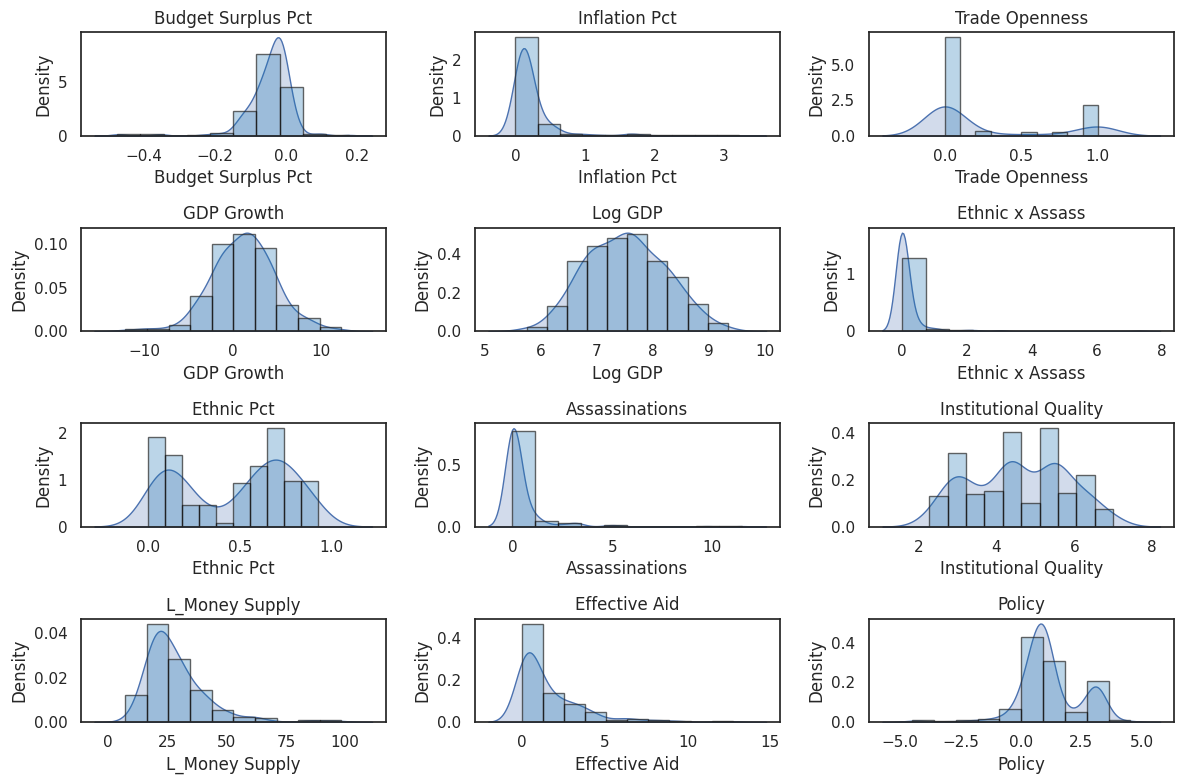

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(12,8), dpi=100)
for var, axis in zip(X_vars, fig.axes):
    g = sns.kdeplot(df[var].groupby(level=['country', 'year1']).agg(np.nanmean), ax=axis, legend=False, shade=True)
    axis.hist(df[var].groupby(level=['country', 'year1']).agg(np.nanmean), density=True, facecolor='Tab:Blue', edgecolor=None,
             alpha=0.3)
    axis.hist(df[var].groupby(level=['country', 'year1']).agg(np.nanmean), density=True, facecolor='None', edgecolor='black',
             alpha=0.6)
    axis.set_title(var)
fig.tight_layout()
plt.show()


In [ ]:
pd.DataFrame((df[X_vars].groupby('year1').agg(np.nanmean).apply(np.nanvar)/df[X_vars].groupby('year1').agg(np.nanmean).apply(np.nanmean)).sort_values(ascending=False))

0
GDP Growth             1.297
L_Money Supply         0.817
Effective Aid          0.140
Trade Openness         0.126
Policy                 0.111
Assassinations         0.068
Inflation Pct          0.033
Ethnic x Assass        0.012
Log GDP                0.000
Ethnic Pct             0.000
Institutional Quality  0.000
Budget Surplus Pct    -0.003

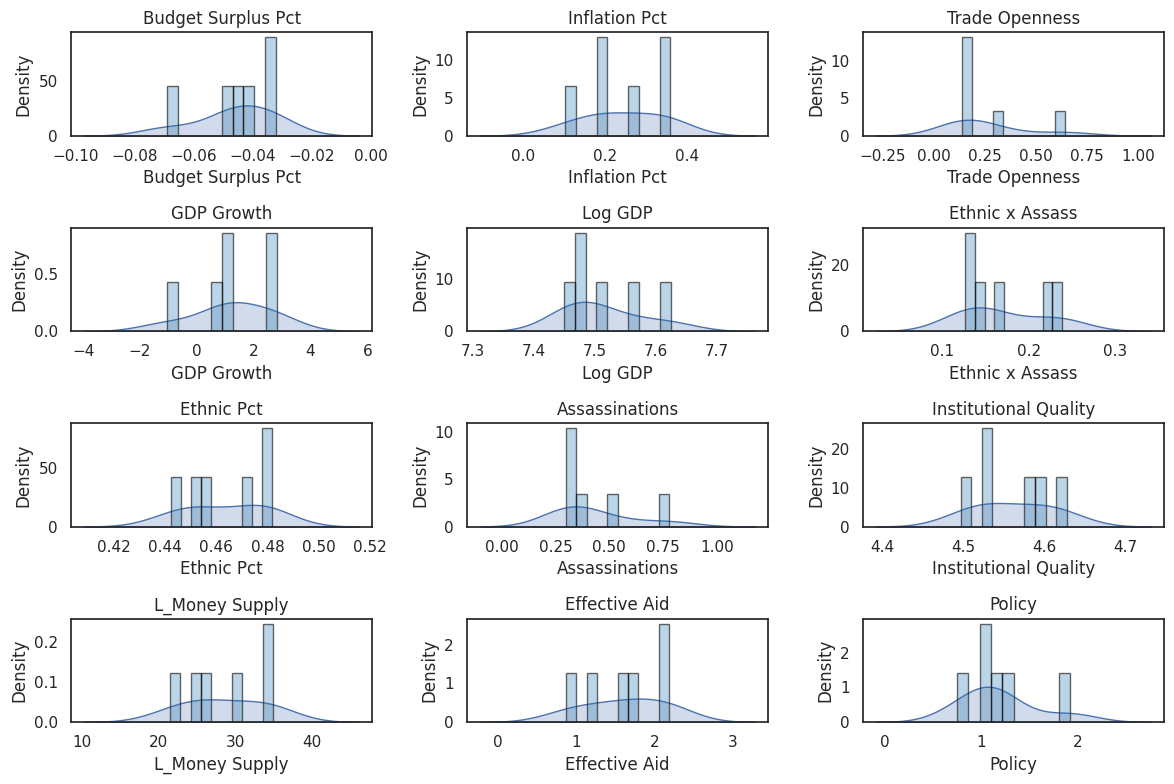

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(12,8), dpi=100)
for var, axis in zip(X_vars, fig.axes):
    g = sns.kdeplot(df[var].groupby('year1').agg(np.nanmean), ax=axis, legend=False, shade=True)
    axis.hist(df[var].groupby('year1').agg(np.nanmean), density=True, facecolor='Tab:Blue', edgecolor=None,
             alpha=0.3)
    axis.hist(df[var].groupby('year1').agg(np.nanmean), density=True, facecolor='None', edgecolor='black',
             alpha=0.6)
    axis.set_title(var)
fig.tight_layout()
plt.show()

In [ ]:
pd.DataFrame((df[X_vars].groupby('country').agg(np.nanmean).apply(np.nanvar)/df[X_vars].groupby('country').agg(np.nanmean).apply(np.nanmean)).sort_values(ascending=False))

0
GDP Growth             5.088
L_Money Supply         4.005
Effective Aid          2.014
Assassinations         1.576
Ethnic x Assass        0.897
Policy                 0.718
Trade Openness         0.418
Institutional Quality  0.321
Inflation Pct          0.270
Ethnic Pct             0.191
Log GDP                0.070
Budget Surplus Pct    -0.046

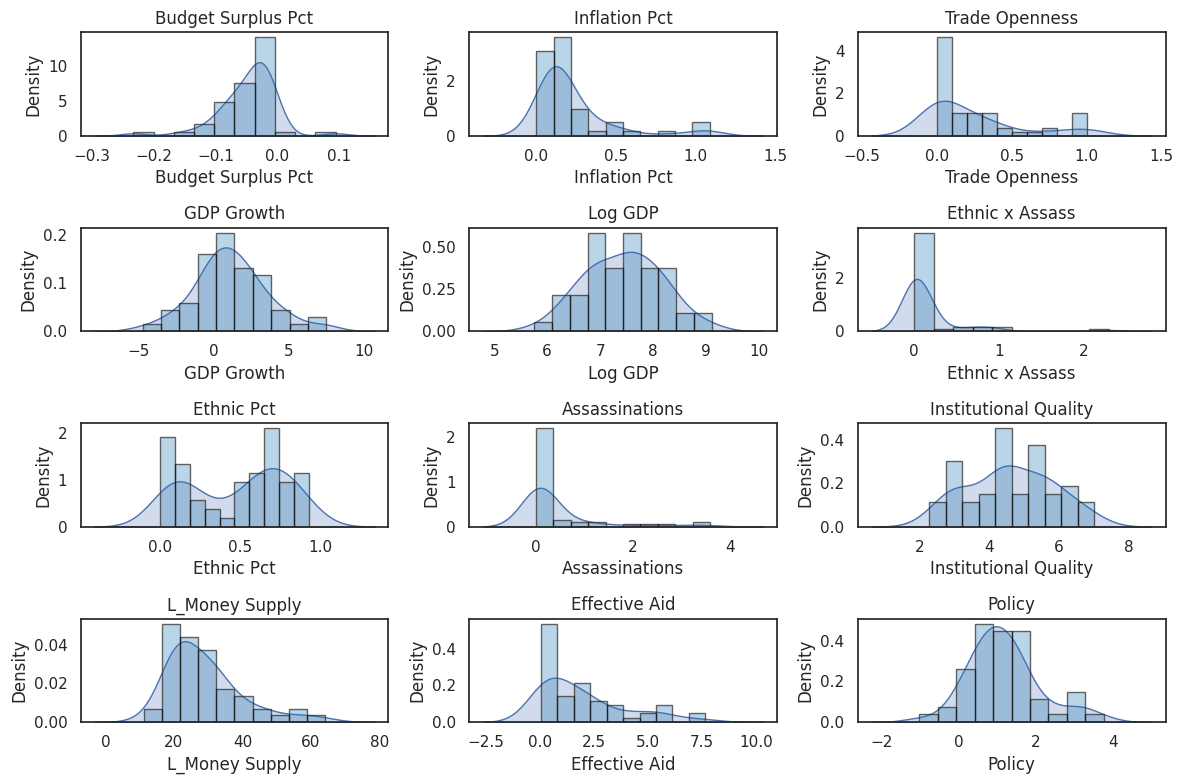

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(12,8), dpi=100)
for var, axis in zip(X_vars, fig.axes):
    g = sns.kdeplot(df[var].groupby('country').agg(np.nanmean), ax=axis, legend=False, shade=True)
    axis.hist(df[var].groupby('country').agg(np.nanmean), density=True, facecolor='Tab:Blue', edgecolor=None,
             alpha=0.3)
    axis.hist(df[var].groupby('country').agg(np.nanmean), density=True, facecolor='None', edgecolor='black',
             alpha=0.6)
    axis.set_title(var)
fig.tight_layout()
plt.show()

In [ ]:
corr = df[X_vars].corr()
corr

Budget Surplus Pct  Inflation Pct  Trade Openness  \
Budget Surplus Pct                  1.000         -0.268           0.165   
Inflation Pct                      -0.268          1.000          -0.012   
Trade Openness                      0.165         -0.012           1.000   
GDP Growth                          0.266         -0.272           0.333   
Log GDP                             0.174          0.165           0.185   
Ethnic x Assass                     0.016          0.061          -0.026   
Ethnic Pct                         -0.103         -0.127          -0.018   
Assassinations                      0.040          0.114           0.042   
Institutional Quality               0.216         -0.077           0.222   
L_Money Supply                     -0.299          0.001           0.136   
Effective Aid                      -0.235         -0.001          -0.040   
Policy                              0.591         -0.542           0.776   

                       GDP Growth  Log GDP  Ethnic x Assass  Ethnic Pct  \
Budget Surplus Pct          0.266    0.174            0.016      -0.103   
Inflation Pct              -0.272    0.165            0.061      -0.127   
Trade Openness              0.333    0.185           -0.026      -0.018   
GDP Growth                  1.000    0.115           -0.039      -0.083   
Log GDP                     0.115    1.000            0.060      -0.468   
Ethnic x Assass            -0.039    0.060            1.000       0.102   
Ethnic Pct                 -0.083   -0.468            0.102       1.000   
Assassinations             -0.063    0.150            0.861      -0.081   
Institutional Quality       0.271    0.324           -0.195      -0.056   
L_Money Supply              0.017    0.148           -0.034      -0.087   
Effective Aid              -0.173   -0.557           -0.130       0.232   
Policy                      0.451    0.121           -0.040       0.006   

                       Assassinations  Institutional Quality  L_Money Supply  \
Budget Surplus Pct              0.040                  0.216          -0.299   
Inflation Pct                   0.114                 -0.077           0.001   
Trade Openness                  0.042                  0.222           0.136   
GDP Growth                     -0.063                  0.271           0.017   
Log GDP                         0.150                  0.324           0.148   
Ethnic x Assass                 0.861                 -0.195          -0.034   
Ethnic Pct                     -0.081                 -0.056          -0.087   
Assassinations                  1.000                 -0.180          -0.030   
Institutional Quality          -0.180                  1.000           0.054   
L_Money Supply                 -0.030                  0.054           1.000   
Effective Aid                  -0.130                 -0.128           0.099   
Policy                         -0.006                  0.269          -0.010   

                       Effective Aid  Policy  
Budget Surplus Pct            -0.235   0.591  
Inflation Pct                 -0.001  -0.542  
Trade Openness                -0.040   0.776  
GDP Growth                    -0.173   0.451  
Log GDP                       -0.557   0.121  
Ethnic x Assass               -0.130  -0.040  
Ethnic Pct                     0.232   0.006  
Assassinations                -0.130  -0.006  
Institutional Quality         -0.128   0.269  
L_Money Supply                 0.099  -0.010  
Effective Aid                  1.000  -0.112  
Policy                        -0.112   1.000

<Axes: >

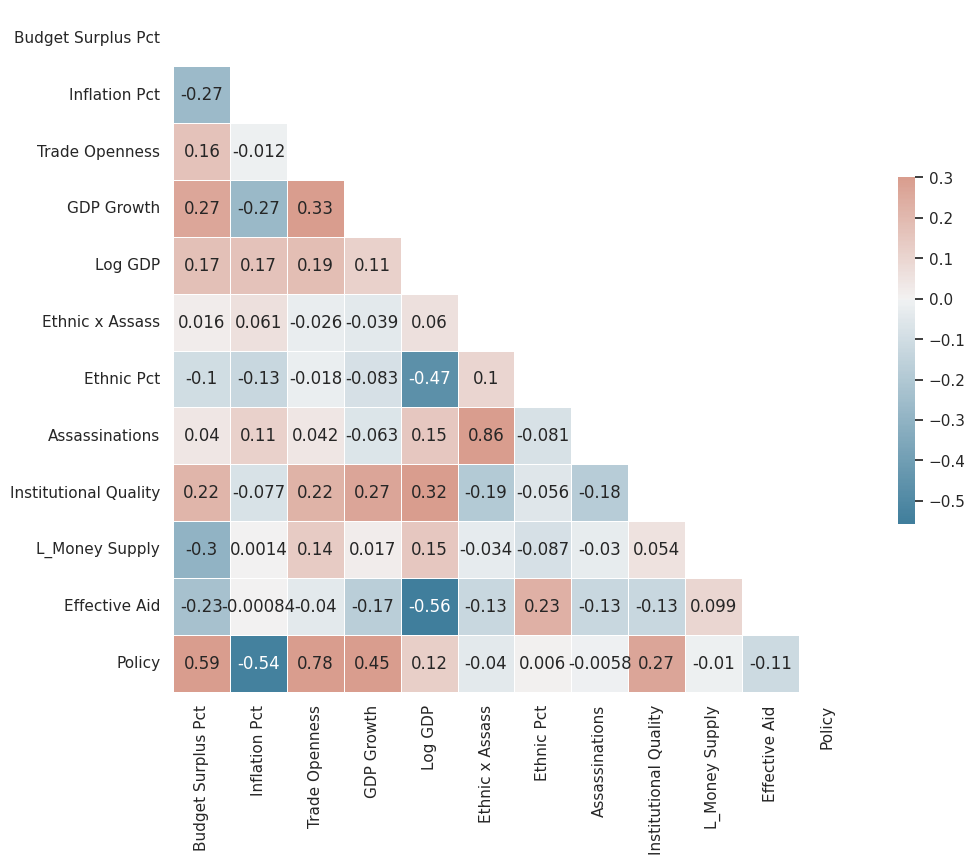

In [ ]:

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

2.	*What is the largest number of period T for individuals? What is the number of individuals?*

The largest number of time periods is 6. 34 countries have 6 time periods present. Since not all do, we are dealing with unbalanced panel data.

In [ ]:
_df = df.groupby('country')
line = ''
print(f'Total Number of Countries: {len(_df.groups.keys())}')
print(f'Total Number of Time Periods: {len(df.groupby("year1").groups.keys())}')
print('\n')
for i in range(6, 0, -1):
    print(f'Countries with {i} time observations: {len(_df.size()[_df.size() == i])}')
print('\n')
print(('Country' + ' '*15 + 'N Times' + ' '*6) * 3)
print('='*100)
for country, count in zip(_df.size().index, _df.size()):
    text = country + ' '*(25-len(country)) + str(count) + ' '*10
    if len(line) < 100:
        line += text
    else:
        print(line)
        line = ''

Total Number of Countries: 56
Total Number of Time Periods: 6


Countries with 6 time observations: 34
Countries with 5 time observations: 6
Countries with 4 time observations: 4
Countries with 3 time observations: 4
Countries with 2 time observations: 5
Countries with 1 time observations: 3


Country               N Times      Country               N Times      Country               N Times      
Algeria                  2          Argentina                6          Bolivia                  6          
Brazil                   6          Cameroon                 5          Chile                    6          
Costa Rica               6          Cote D'Ivoire            1          Dominican Republic       6          
Egypt                    5          El Salvador              6          Ethiopia                 2          
Gambia, The              6          Ghana                    6          Guatemala                6          
Haiti                    5          Honduras          

3.	*Comment on the structure of the unbalanced panel (how many (and which) countries have a single observation, discontinuities between observations, how many have at least 2 consecutive observations (which is useful to compute lags, autocorrelations, first difference and within estimators)?*

Cote d'Ivoire, Mali, and Turkey only have a single observation. All others except for Algeria, Ethiopia, and Tanzania have at least two consecutive observations. The missing observations tend to be at the beginning and the end of our sample's time periods.

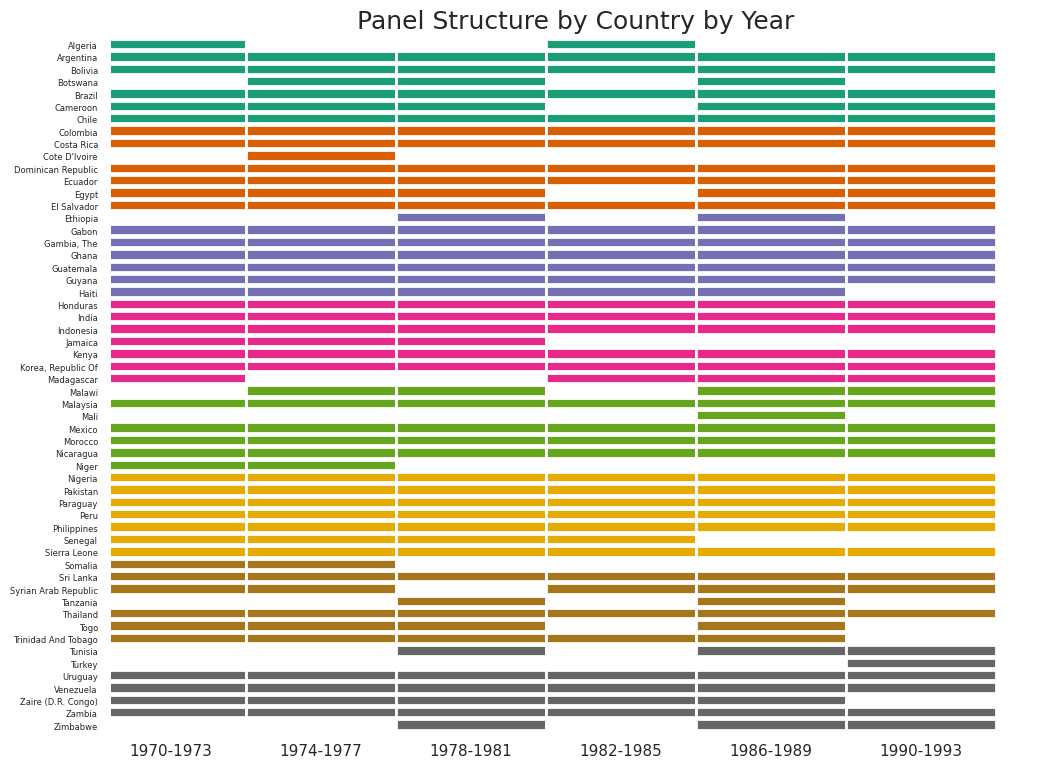

In [ ]:
all_years = set(df.index.get_level_values(1).unique())
space = 0.3
fig_height = len(_df.groups.keys()) * space
fig_length = len(all_years)
cmap = cm.get_cmap('Dark2')
gradient = cmap(np.linspace(0,1,len(_df.groups.keys())))

fig, ax = plt.subplots(figsize=(8*1.5,6*1.5), dpi=100)
ax.set_ylim(0, fig_height)
ax.set_xlim(-0.2, fig_length)
for i, country in enumerate(_df.groups.keys()):
    present = list(set(_df.get_group(country).index.get_level_values(1)))
    y1 = [1 if xx in present else 0 for xx in all_years]
    for j, color in enumerate(y1):
        x_cord = 0+j*(fig_length/len(all_years)) - 0.3
        y_cord = fig_height-i*space - 0.3
        if color == 1:
            fc = gradient[i].squeeze().tolist()
        else:
            fc = 'white'
        rect = patches.Rectangle(xy=(x_cord, y_cord),
                            width=fig_length/len(all_years),
                            height=0.25,
                            linewidth=2,
                            edgecolor='white',
                            facecolor=fc)

        ax.add_patch(rect)
ax.set_yticks([fig_height - 0.2 - i * space for i in range(len(_df.groups.keys()))])
ax.set_yticklabels(_df.groups.keys(), fontsize=6)
ax.set_xticks(np.array([0,1,2,3,4,5]) + 0.2)
ax.set_xticklabels(df.index.get_level_values(1).unique().sort_values().to_list())
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(which='both',
              axis='both',
              left=False,
              right=False,
              top=False,
              bottom=False)
ax.set_title('Panel Structure by Country by Year', fontsize=18, )
plt.show()

In [ ]:
all_years = set(df.index.get_level_values(1).unique())
_df = df.groupby('country')
unbalanced_countries = df.index.get_level_values(0).unique()[df.groupby('country').size() < 6]

space = 0.3
fig_height = len(unbalanced_countries) * space
fig_length = len(all_years)
cmap = cm.get_cmap('Dark2')
gradient = cmap(np.linspace(0,1,len(unbalanced_countries)))

fig, ax = plt.subplots(figsize=(8*1.5,6*1.5), dpi=100)
ax.set_ylim(0, fig_height)
ax.set_xlim(-0.2, fig_length)
for i, country in enumerate(unbalanced_countries):
    present = list(set(_df.get_group(country).index.get_level_values(1)))
    y1 = [1 if xx in present else 0 for xx in all_years]
    for j, color in enumerate(y1):
        x_cord = 0+j*(fig_length/len(all_years)) - 0.3
        y_cord = fig_height-i*space - 0.3
        if color == 1:
            fc = gradient[i].squeeze().tolist()
        else:
            fc = 'white'
        rect = patches.Rectangle(xy=(x_cord, y_cord),
                            width=fig_length/len(all_years),
                            height=0.25,
                            linewidth=2,
                            edgecolor='white',
                            facecolor=fc)

        ax.add_patch(rect)
ax.set_yticks([fig_height - 0.2 - i * space for i in range(len(unbalanced_countries))])
ax.set_yticklabels(unbalanced_countries, fontsize=12)
ax.set_xticks(np.array([0,1,2,3,4,5]) + 0.2)
ax.set_xticklabels(df.index.get_level_values(1).unique().sort_values().to_list())
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(which='both',
              axis='both',
              left=False,
              right=False,
              top=False,
              bottom=False)
ax.set_title('Panel Structure by Country by Year, \n Unbalanced Panels Only', fontsize=18, )
plt.show()

In [ ]:
pd.DataFrame(df.groupby('year1').size())

0
year1        
1970-1973  41
1974-1977  47
1978-1981  48
1982-1985  48
1986-1989  49
1990-1993  42

4.	*Compute between transformed and one-way-within transformed variables for all variables. Present a table with the one-way-within-fixed-effects, between and pooled variance for each variable. Compute the share of between and within variance in the total variance for each variable. Comment these results.*


The highest variance is in L_Money Supply, GDP Growth, and with Effective Aid. Institutional Quality has no within variance. The variances are lower for Between and even lower for Within. This tells us that counties have more differences with each other than they do within different time periods in the same country. That tells us there is stickiness within countries and there are individual effects.

In [ ]:
overall = df[X_vars] - df[X_vars].mean()
between = df[X_vars].groupby('country').agg(np.nanmean)

#The transform method is fancy, it takes the subgroups made by groupby, applies a function and casts the results back
#to the shape of the original dataframe. In this case, it allows us compute the inter-individual mean, then cast it back
#onto the time-dimension values.

within = df[X_vars].groupby('country').transform(lambda x: x - x.mean())


table = pd.concat([overall.var(), between.var(), within.var()], axis=1)
table.columns = ['Pooled', 'Between', 'Within']
table.loc[table.apply(sum, axis=1).sort_values(ascending=False).index]


Pooled  Between  Within
L_Money Supply        176.296  117.840  63.591
GDP Growth             12.952    5.686   8.133
Effective Aid           4.281    3.944   1.203
Policy                  1.592    0.851   0.736
Assassinations          1.526    0.658   0.911
Institutional Quality   1.529    1.503   0.000
Log GDP                 0.492    0.527   0.031
Ethnic x Assass         0.365    0.140   0.209
Trade Openness          0.174    0.105   0.074
Inflation Pct           0.156    0.063   0.086
Ethnic Pct              0.090    0.092   0.000
Budget Surplus Pct      0.004    0.002   0.002

5.	*Plot the distribution of the one-way-fixed-effects-within (x(it)-x(i.)) and between (x(i.)) transformed dependent variable and of you key (preferred) explanatory variable (not all the explanatory variable) [in Burnside and Dollar: GDP growth and foreign aid EDA/GDP], using on the same graph an histogram, a normal law with same empirical mean and standard error and a kernel continuous approximation. Comment the between and within difference for each variable, and compare within/within for dependent and explanatory variable, and between/between for dependent and explanatory variable: kurtosis, skewness, non-normality, high leverage observation (far from the mean), several modes (mixture of distribution)?*


The GDP growth and policy distributions for within are centered about the mean. For between, the mean is slightly above 1. GDP growth has wider distributions, whereas policy has more kurtosis. This tells us the GDP growth has a higher variance whereas policy is more consistent period to period.

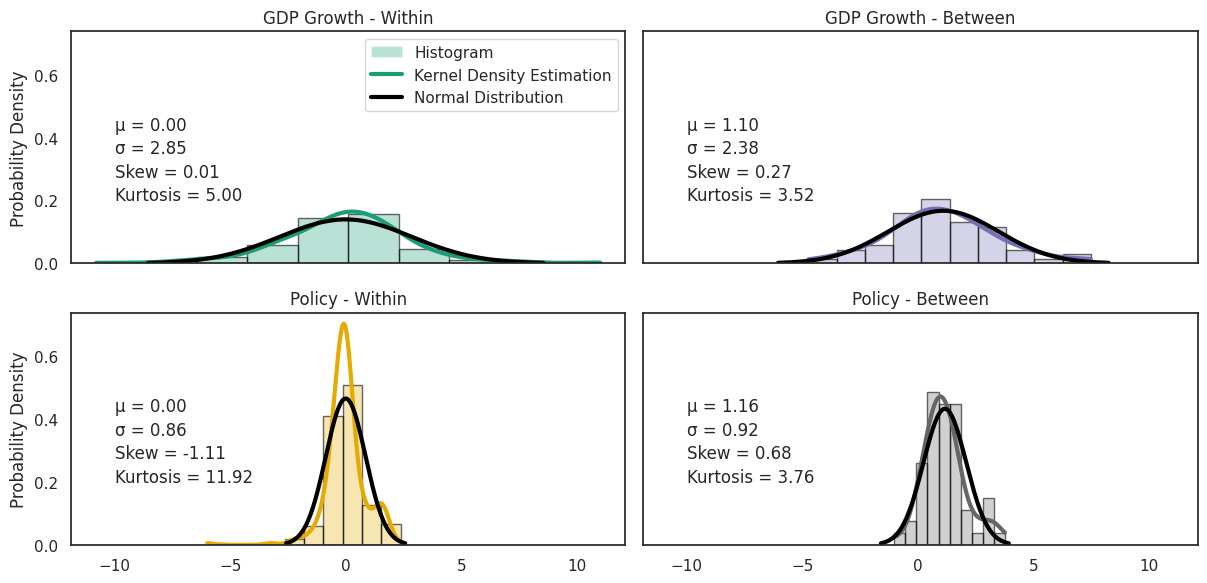

In [ ]:
import itertools
cmap = cm.get_cmap('Dark2')
gradient = cmap(np.linspace(0,1,4))

fig, ax = plt.subplots(2, 2, figsize=(12,6), dpi=100, sharex=True, sharey=True)
vars_to_plot = ['GDP Growth', 'Policy']
estimators = [('Within', within), ('Between', between)]
combos = itertools.product(vars_to_plot, estimators)
for (v, (name, estimator)), axis, c in zip(combos, fig.axes, gradient):

    kde = stats.gaussian_kde(estimator[v])
    xx = np.linspace(min(estimator[v]), max(estimator[v]), 1000)

    mean = estimator[v].mean()
    std = estimator[v].std()
    skew = stats.skew(estimator[v])
    kur = stats.kurtosis(estimator[v], fisher=False)

    pdf_x = np.linspace(mean - 3*std, mean + 3*std, 1000)
    pdf = stats.norm.pdf(pdf_x, mean, std)
    c = c.squeeze().tolist()

    face = axis.hist(estimator[v], bins=10, density=True, edgecolor=None, color=c, alpha=0.3, label='Histogram')
    line = axis.hist(estimator[v], bins=10, density=True, edgecolor='black', facecolor='None', alpha=0.6)
    axis.plot(xx, kde(xx), color=c, lw=3, alpha=1, label='Kernel Density Estimation')
    axis.plot(pdf_x, pdf, color='black', lw=3, label='Normal Distribution')
    axis.set_title(v + ' - ' + name)
    axis.text(-10, .425, f'μ = {mean:0.2f}')
    axis.text(-10, 0.35, f'σ = {std:0.2f}')
    axis.text(-10, 0.275, f'Skew = {skew:0.2f}')
    axis.text(-10, 0.2, f'Kurtosis = {kur:0.2f}')

fig.tight_layout()
ax[0][0].set_ylabel('Probability Density')
ax[1][0].set_ylabel('Probability Density')
ax[0][0].legend()
plt.show()

6.	*Compute first-differences and two-way-fixed-effects (x(it)-x(i.)-x(.t)+x(..)) transformed variables (these two transformations eliminate deterministic trend, to be checked in correlation matrix). For first-differences for panel data, check that when you change individual, the first observation is missing with a dot, and it is not the difference of the first observation of the second individual minus the last observation of the first individual, for example. Plot the distribution for dependent GDPG and explanatory EDA/GDP for each of these two transformations. Compare with one-way-fixed effects and between distributions.*


GDP growth has a roughly normal distribution for both two-way fixed effects and for first-differences. Policy, however, has excess kurtosis for first-differences. This tells us that period-over-period there is little change in Policy within a country.

In [ ]:
df['GDP Growth fd'] = df['GDP Growth'].diff()
df['Policy fd'] = df['Policy'].diff()

In [ ]:
# prompt: Calculate two way fixed effects for df[X_vars]

df['GDP Growth 2wfe'] = df['GDP Growth'].transform(lambda x: x.groupby(['country', 'year1']).mean() - x.groupby('country').mean() - x.groupby('year1').mean() + x.mean())
df['Policy 2wfe'] = df['Policy'].transform(lambda x: x.groupby(['country', 'year1']).mean() - x.groupby('country').mean() - x.groupby('year1').mean() + x.mean())


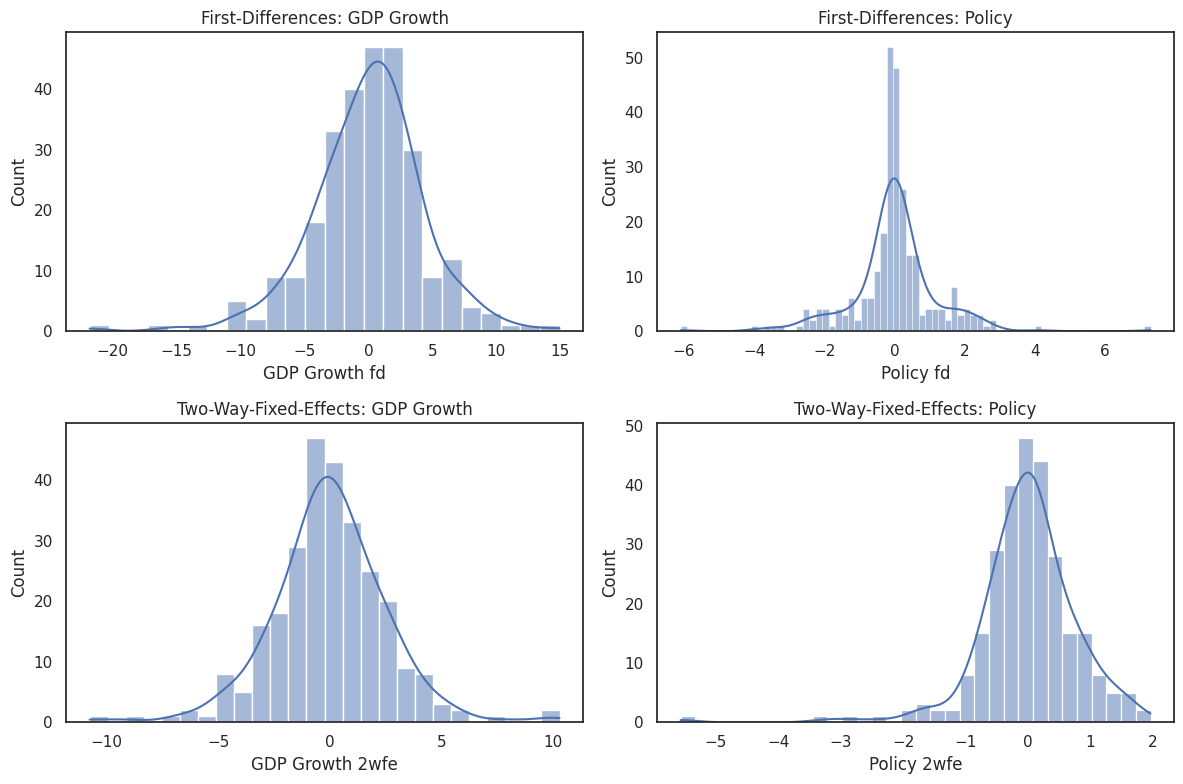

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), dpi=100)

palette = sns.color_palette()
sns.set_palette(palette)

sns.histplot(df['GDP Growth fd'].dropna(), kde=True, ax=ax[0, 0])
ax[0, 0].set_title('First-Differences: GDP Growth')
sns.histplot(df['Policy fd'].dropna(), kde=True, ax=ax[0, 1])
ax[0, 1].set_title('First-Differences: Policy')
sns.histplot(df['GDP Growth 2wfe'].dropna(), kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Two-Way-Fixed-Effects: GDP Growth')
sns.histplot(df['Policy 2wfe'].dropna(), kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Two-Way-Fixed-Effects: Policy')
plt.tight_layout()
plt.show()

7.	*Plot boxplots of between distribution (all countries), then one-way and two-way-fixed effects and first differences distribution BY countries (or 20 individuals if your data set has more than 20 individuals), for the dependent variable and the key explanatory variables. Comment that you find the same insights from question 5. Comment on their differences of standard errors and means for each individuals*


We find the exact same results as in question 5. Notably Gabon is an outlier for GDP Growth within with both the highest and lowest value.

In [ ]:
temp1 = within['GDP Growth'].to_frame()
temp1['Transform'] = 'Within'
temp2 = within['Policy'].to_frame()
temp2['Transform'] = 'Within'
temp3 = between['GDP Growth'].to_frame()
temp3['Transform'] = 'Between'
temp4 = between['Policy'].to_frame()
temp4['Transform'] = 'Between'

long_frame = None
for frame in [temp1, temp2, temp3, temp4]:
    frame.columns = [x + ' ' + frame['Transform'][0] for x in frame.columns]
    if long_frame is None:
        long_frame = frame
    else:
        long_frame = pd.merge(long_frame, frame, how='outer', left_index=True, right_index=True)


In [ ]:
long_frame = long_frame[long_frame.columns[::2]].reset_index().melt(id_vars=['country', 'year1'])


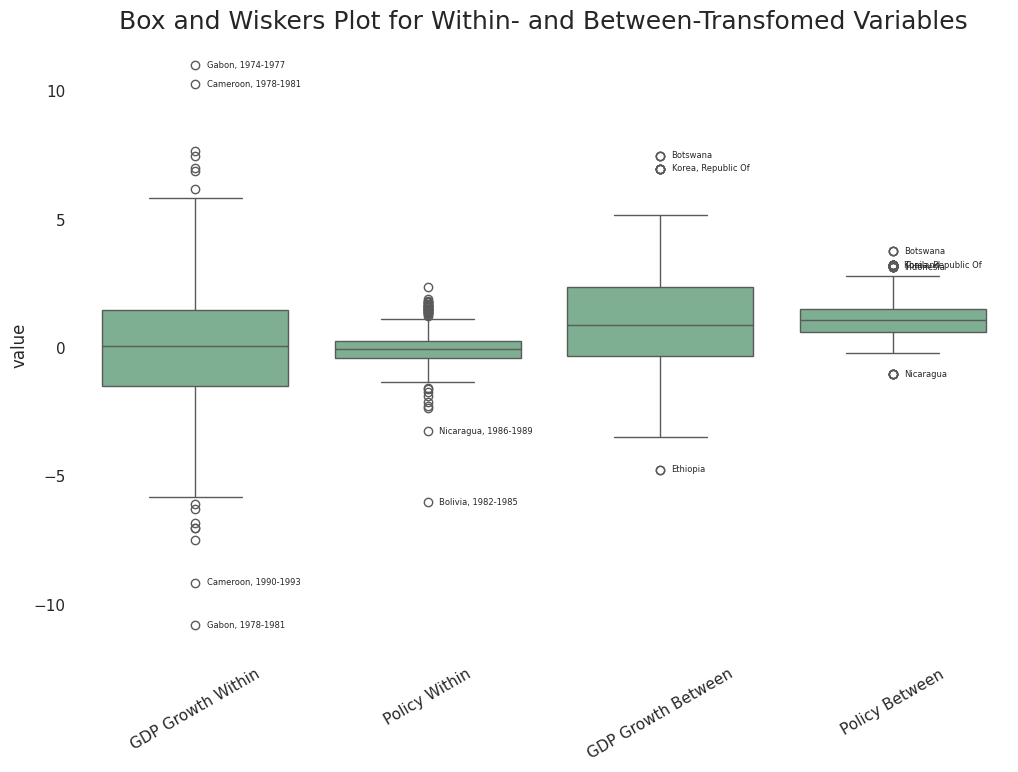

In [ ]:
fig, ax = plt.subplots(figsize=(12,8), dpi=100)
g = sns.boxplot(x='variable', y='value', data=long_frame, ax=ax)
g.set_xlabel('')
g.tick_params(axis='x',
              rotation=30)
g.tick_params(which='both',
             axis='both',
             left=False,
             right=False,
             top=False,
             bottom=False)

combos = [('GDP Growth', within), ('Policy', within),
         ('GDP Growth', between), ('Policy', between)]

for i, (v, estimator) in enumerate(combos):
    if estimator is within:
        μ = estimator[v].mean()
        σ = estimator[v].std()
        outliers = estimator[(estimator[v] < μ - 3*σ) | (estimator[v] > μ + 3*σ)][v]
        countries = outliers.index
    else:
        Q3 = estimator[v].quantile(0.75)
        Q1 = estimator[v].quantile(0.25)
        iqr = Q3 - Q1
        outliers = estimator[(estimator[v] < (Q1 - iqr * 1.4)) | (estimator[v] > (Q3 + iqr * 1.4))][v]
        countries = outliers.index

    for outlier, country in zip(outliers, countries):
        if isinstance(country, tuple):
            text = re.findall("(?<=\')(\w+\W? ?\w*\W? ?\w*)(?=\')",str(country))
            s = text[0].replace('\'', '').replace(',', '').strip() + ', ' + text[1]
        else:
            s = country
        ax.annotate(s, xy=(0.05+i, outlier-0.1), fontsize=6)


for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('Box and Wiskers Plot for Within- and Between-Transfomed Variables', fontsize=18)
plt.show()


8.	*Compute univariate descriptive statistics (min, Q1, median, Q3, max, mean, standard error) for one-way-Within, Between, two-way-fixed-effects and first differences transformed variables. Is the mean different from the median and why? How many standard errors from the mean are the MIN and MAX extremes (report (MAX-average)/standard error and (MIN-average)/standard error in the tables)?*

For all, the mean is roughly equal to the median. This makes sense since the variables have been centered and have roughly normal distributions with few outliers. The min and max values can be five standard errors away, which shows that outliers can stray from expectation given our low-ish observation count.

In [ ]:
combos = itertools.product(vars_to_plot, estimators)
for i, (v, (name, estimator)) in enumerate(combos):
    s = estimator[v].describe()
    s.name = s.name + ' ' + name
    s = s[1:]
    s['median'] = estimator[v].median()
    s = np.round(s, 5)
    if i == 0:
        temp_frame = s.to_frame()
    else:
        temp_frame = temp_frame.merge(s, left_index=True, right_index=True)
temp_frame.loc[['mean', 'median', 'std', 'min', 'max', '25%', '75%'], :]

GDP Growth Within  GDP Growth Between  Policy Within  Policy Between
mean                0.000               1.098          0.000           1.164
median              0.078               0.877         -0.043           1.012
std                 2.852               2.385          0.858           0.923
min               -10.797              -4.736         -5.992          -1.025
max                11.009               7.483          2.385           3.764
25%                -1.486              -0.322         -0.371           0.579
75%                 1.486               2.446          0.270           1.542

9.	*Compare and comment the between versus one-way-within transformed bivariate correlation matrix for all variables (include a time trend 1,2,.,T) and with their lag (for time varying variables). Check poor simple correlation with the dependent variables and high correlation between explanatory variables.*


For within, the time invariant variables have a correlation of zero. The highest positive correlations are assassinations with ethnic x assassinations, and policy with the terms that compose it (like trade openness). The strongest negative correlations are GDP growth and inflation and also Log GDP and Effective Aid.

For betweem, the strongest negative correlation is between Log GDP and Effective Aid. This tells us that more developed countries recieve less aid.

<Axes: >

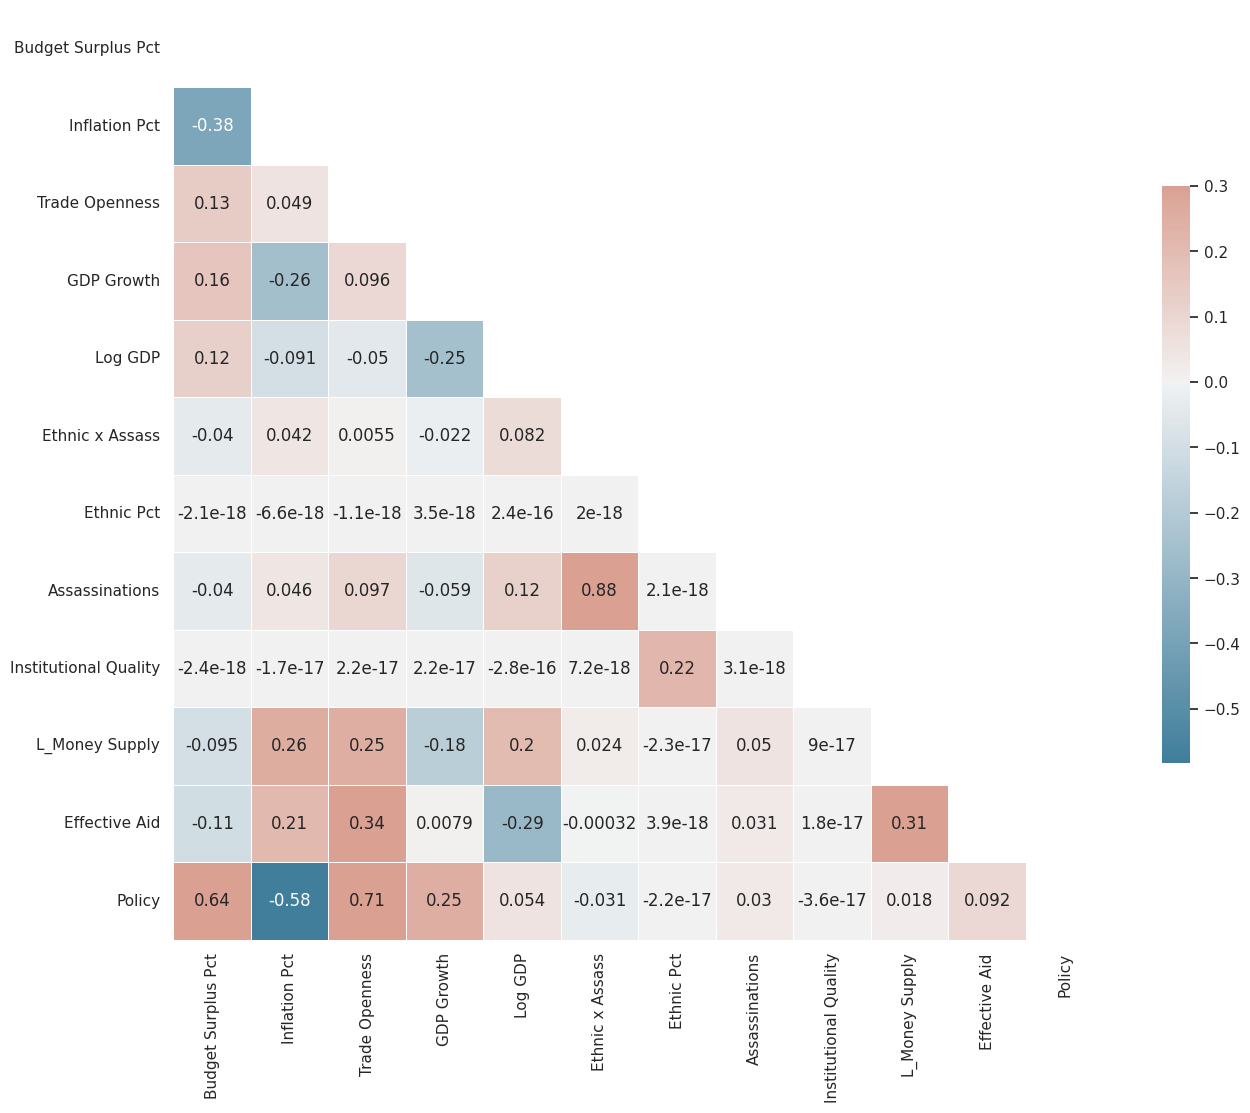

In [ ]:

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(within.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<Axes: >

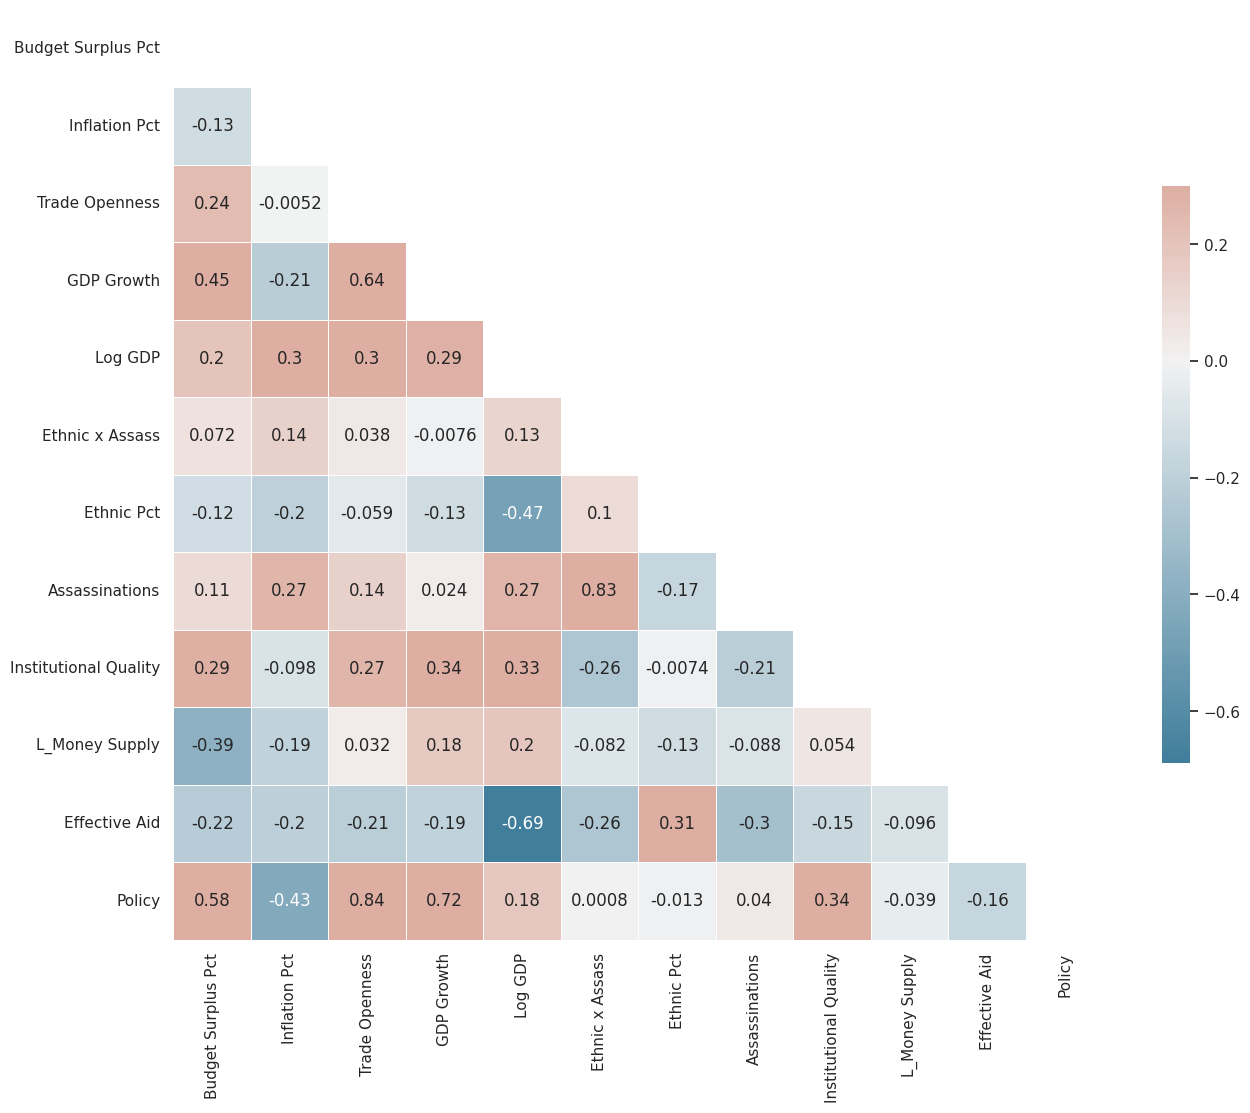

In [ ]:

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(between.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

10.	*Comment the bivariate auto-correlation and trend-correlations (check the number of observations).*


Across all, the highest auto-correlations are with variables that are persistent such as policy and government related factors. Another sticky variable is the L_money_supply and inflation. We know that money supply and inflation are persistent between time periods unless there is a drastic intervention. The time periods with the most variation are the mid-1980s and the early-1970s. These are both inflationary periods in the developing world.

In [ ]:
df.groupby('year1').size()

year1
1970-1973    41
1974-1977    47
1978-1981    48
1982-1985    48
1986-1989    49
1990-1993    42
dtype: int64

In [ ]:
n = df.groupby('year1').size().values
w = n / max(n)
w = w / w.sum()
print(f'Weights: {w}')
print(f'Verify weights sum to 1: {w.sum():0.8f}')


Weights: [0.14909091 0.17090909 0.17454545 0.17454545 0.17818182 0.15272727]
Verify weights sum to 1: 1.00000000


In [ ]:
print('Correlation for each variable and it\'s first lag, within Transformed')
print('='*68)
print(' '*25 + 'Lag 1' + ' '*10 + 'Trend' + ' '*10 + 'N Obs')
print(' '*25 + '=====' + ' '*10 + '=====' + ' '*10 + '=====')

for var in X_vars:
    n_obs = str(within.groupby('year1').agg(np.nanmean)[var].shape[0])
    vals = within.groupby('year1').agg(np.nanmean)[var] * w
    line = ''
    corr, p = stats.pearsonr(vals.iloc[1:], vals.shift(1).dropna(), )
    line = var + ' '*(25 - len(var))
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'
    line += (stat + ' ' * (16 - len(stat)))

    corr, p = stats.pearsonr(vals, within[var].groupby('year1').agg(np.nanmean))
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'

    line += (stat + ' ' * (16 - len(stat)))
    line += n_obs
    print(line)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Correlation for each variable and it's first lag, within Transformed
                         Lag 1          Trend          N Obs
                         =====          =====          =====
Budget Surplus Pct       0.16            1.00***         6
Inflation Pct            0.80            1.00***         6
Trade Openness           0.87*           1.00***         6
GDP Growth               0.40            1.00***         6
Log GDP                  0.78            1.00***         6
Ethnic x Assass          -0.26           1.00***         6
Ethnic Pct               -0.20           0.98***         6
Assassinations           -0.30           1.00***         6
Institutional Quality    nan             nan             6
L_Money Supply           0.94**          1.00***         6
Effective Aid            0.95**          1.00***         6
Policy                   0.19            1.00***         6


*** - p < 0.01, ** - p < 0.05, * - p < 0.01
Note: Pearson's correlation coefficient assumes normall

In [ ]:
print('Correlation for each variable and it\'s first lag, untransforrmed')
print('='*68)
print(' '*25 + 'Lag 1' + ' '*10 + 'Trend' + ' '*10 + 'N Obs')
print(' '*25 + '=====' + ' '*10 + '=====' + ' '*10 + '=====')

for var in X_vars:
    n_obs = str(overall.groupby('year1').agg(np.nanmean)[var].shape[0])
    vals = overall.groupby('year1').agg(np.nanmean)[var] * w
    line = ''
    corr, p = stats.pearsonr(vals.iloc[1:], vals.shift(1).dropna(), )
    line = var + ' '*(25 - len(var))
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'
    line += (stat + ' ' * (16 - len(stat)))

    corr, p = stats.pearsonr(vals, within[var].groupby('year1').agg(np.nanmean))
    if p < 0.01:
        stat = f'{corr:0.2f}***'
    elif p < 0.05:
        stat = f'{corr:0.2f}**'
    elif p < 0.10:
        stat = f'{corr:0.2f}*'
    else:
        stat = f'{corr:0.2f}'

    line += (stat + ' ' * (16 - len(stat)))
    line += n_obs
    print(line)
print('\n')
print('*** - p < 0.01, ** - p < 0.05, * - p < 0.01')
print('Note: Pearson\'s correlation coefficient assumes normally distributed variables')

Correlation for each variable and it's first lag, untransforrmed
                         Lag 1          Trend          N Obs
                         =====          =====          =====
Budget Surplus Pct       0.15            0.99***         6
Inflation Pct            0.85*           0.99***         6
Trade Openness           0.89**          1.00***         6
GDP Growth               0.36            1.00***         6
Log GDP                  -0.34           0.63            6
Ethnic x Assass          -0.48           0.94***         6
Ethnic Pct               0.09            0.64            6
Assassinations           -0.44           0.97***         6
Institutional Quality    0.09            0.39            6
L_Money Supply           0.93**          1.00***         6
Effective Aid            0.87*           0.91**          6
Policy                   0.22            1.00***         6


*** - p < 0.01, ** - p < 0.05, * - p < 0.01
Note: Pearson's correlation coefficient assumes normally di

In [ ]:
overall.groupby('year1').agg(np.nanmean)['GDP Growth']

year1
1970-1973    1.629
1974-1977    1.304
1978-1981   -0.032
1982-1985   -2.236
1986-1989   -0.378
1990-1993   -0.017
Name: GDP Growth, dtype: float64

In [ ]:
within.groupby('year1').agg(np.nanmean)['GDP Growth']

year1
1970-1973    1.591
1974-1977    1.346
1978-1981   -0.022
1982-1985   -2.090
1986-1989   -0.399
1990-1993   -0.180
Name: GDP Growth, dtype: float64

11.	*Compare and comment the two-way within or first differences transformed bivariate correlation matrix for all variables (include a deterministic time trend 1,2,.,T). Check zero correlation with deterministic time trend. Check poor simple correlation with the dependent variables and high correlation between explanatory variables. Check the auto-correlation  (with lag correctly computed for panel data).*


Again, the strongest autocorrelation is with policy and inflation.

In [ ]:
firstdiff = pd.DataFrame()
for x in X_vars:
  firstdiff[x] = df.groupby('country')[x].diff()


In [ ]:
firstdiff["t_trend"] = -99
firstdiff["year1"]= firstdiff.swaplevel().index.get_level_values("year1")
firstdiff.loc[firstdiff["year1"] =="1970-1973","t_trend"] =0
firstdiff.loc[firstdiff["year1"] =="1974-1977","t_trend"] =1
firstdiff.loc[firstdiff["year1"] =="1978-1981","t_trend"] =2
firstdiff.loc[firstdiff["year1"] =="1982-1985","t_trend"] =3
firstdiff.loc[firstdiff["year1"] =="1986-1989","t_trend"] =4
firstdiff.loc[firstdiff["year1"] =="1990-1993","t_trend"] =5
firstdiff.drop("year1", axis=1, inplace=True)

firstdiff

Budget Surplus Pct  Inflation Pct  Trade Openness  \
country   year1                                                          
Algeria   1970-1973                 NaN            NaN             NaN   
          1974-1977               0.105          0.036           0.000   
Argentina 1970-1973                 NaN            NaN             NaN   
          1974-1977              -0.048          0.649           0.000   
          1978-1981               0.035         -0.145           0.000   
...                                 ...            ...             ...   
Zambia    1986-1989              -0.007          0.309           0.000   
          1990-1993               0.026          0.386           0.250   
Zimbabwe  1982-1985                 NaN            NaN             NaN   
          1986-1989              -0.004         -0.032           0.000   
          1990-1993               0.021          0.130           0.000   

                     GDP Growth  Log GDP  Ethnic x Assass  Ethnic Pct  \
country   year1                                                         
Algeria   1970-1973         NaN      NaN              NaN         NaN   
          1974-1977       0.850    0.211            0.000       0.000   
Argentina 1970-1973         NaN      NaN              NaN         NaN   
          1974-1977      -0.623    0.090            2.170       0.000   
          1978-1981      -2.193   -0.053           -2.712       0.000   
...                         ...      ...              ...         ...   
Zambia    1986-1989       3.032   -0.179            0.000       0.000   
          1990-1993      -1.012   -0.132            0.000       0.000   
Zimbabwe  1982-1985         NaN      NaN              NaN         NaN   
          1986-1989       1.173   -0.123           -0.405       0.000   
          1990-1993      -2.554    0.003            0.000       0.000   

                     Assassinations  Institutional Quality  L_Money Supply  \
country   year1                                                              
Algeria   1970-1973             NaN                    NaN             NaN   
          1974-1977           0.000                  0.000          12.360   
Argentina 1970-1973             NaN                    NaN             NaN   
          1974-1977           7.000                  0.000           3.968   
          1978-1981          -8.750                  0.000           1.441   
...                             ...                    ...             ...   
Zambia    1986-1989           0.000                  0.000           4.522   
          1990-1993           0.000                  0.000          -2.193   
Zimbabwe  1982-1985             NaN                    NaN             NaN   
          1986-1989          -0.750                  0.000          -3.643   
          1990-1993           0.000                  0.000           0.519   

                     Effective Aid  Policy  t_trend  
country   year1                                      
Algeria   1970-1973            NaN     NaN        0  
          1974-1977         -0.531   0.668        1  
Argentina 1970-1973            NaN     NaN        0  
          1974-1977         -0.001  -1.236        1  
          1978-1981          0.007   0.444        2  
...                            ...     ...      ...  
Zambia    1986-1989          2.018  -0.479        4  
          1990-1993          3.264   0.178        5  
Zimbabwe  1982-1985            NaN     NaN        3  
          1986-1989          0.121   0.019        4  
          1990-1993          0.875  -0.038        5  

[275 rows x 13 columns]

<Axes: >

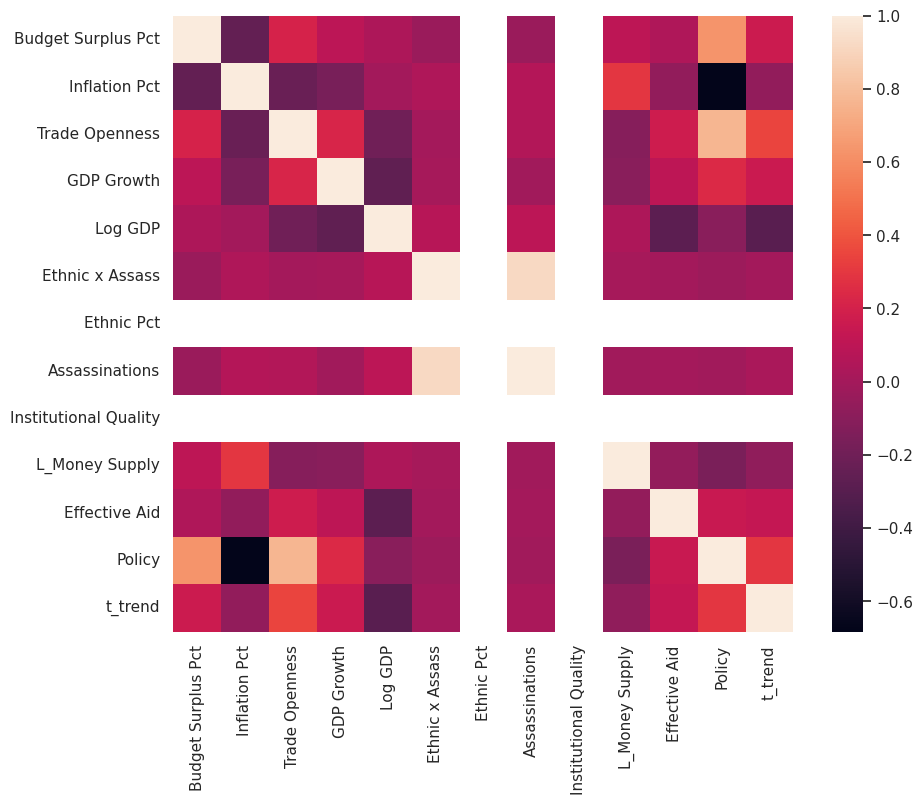

In [ ]:
sns.heatmap(firstdiff.corr())

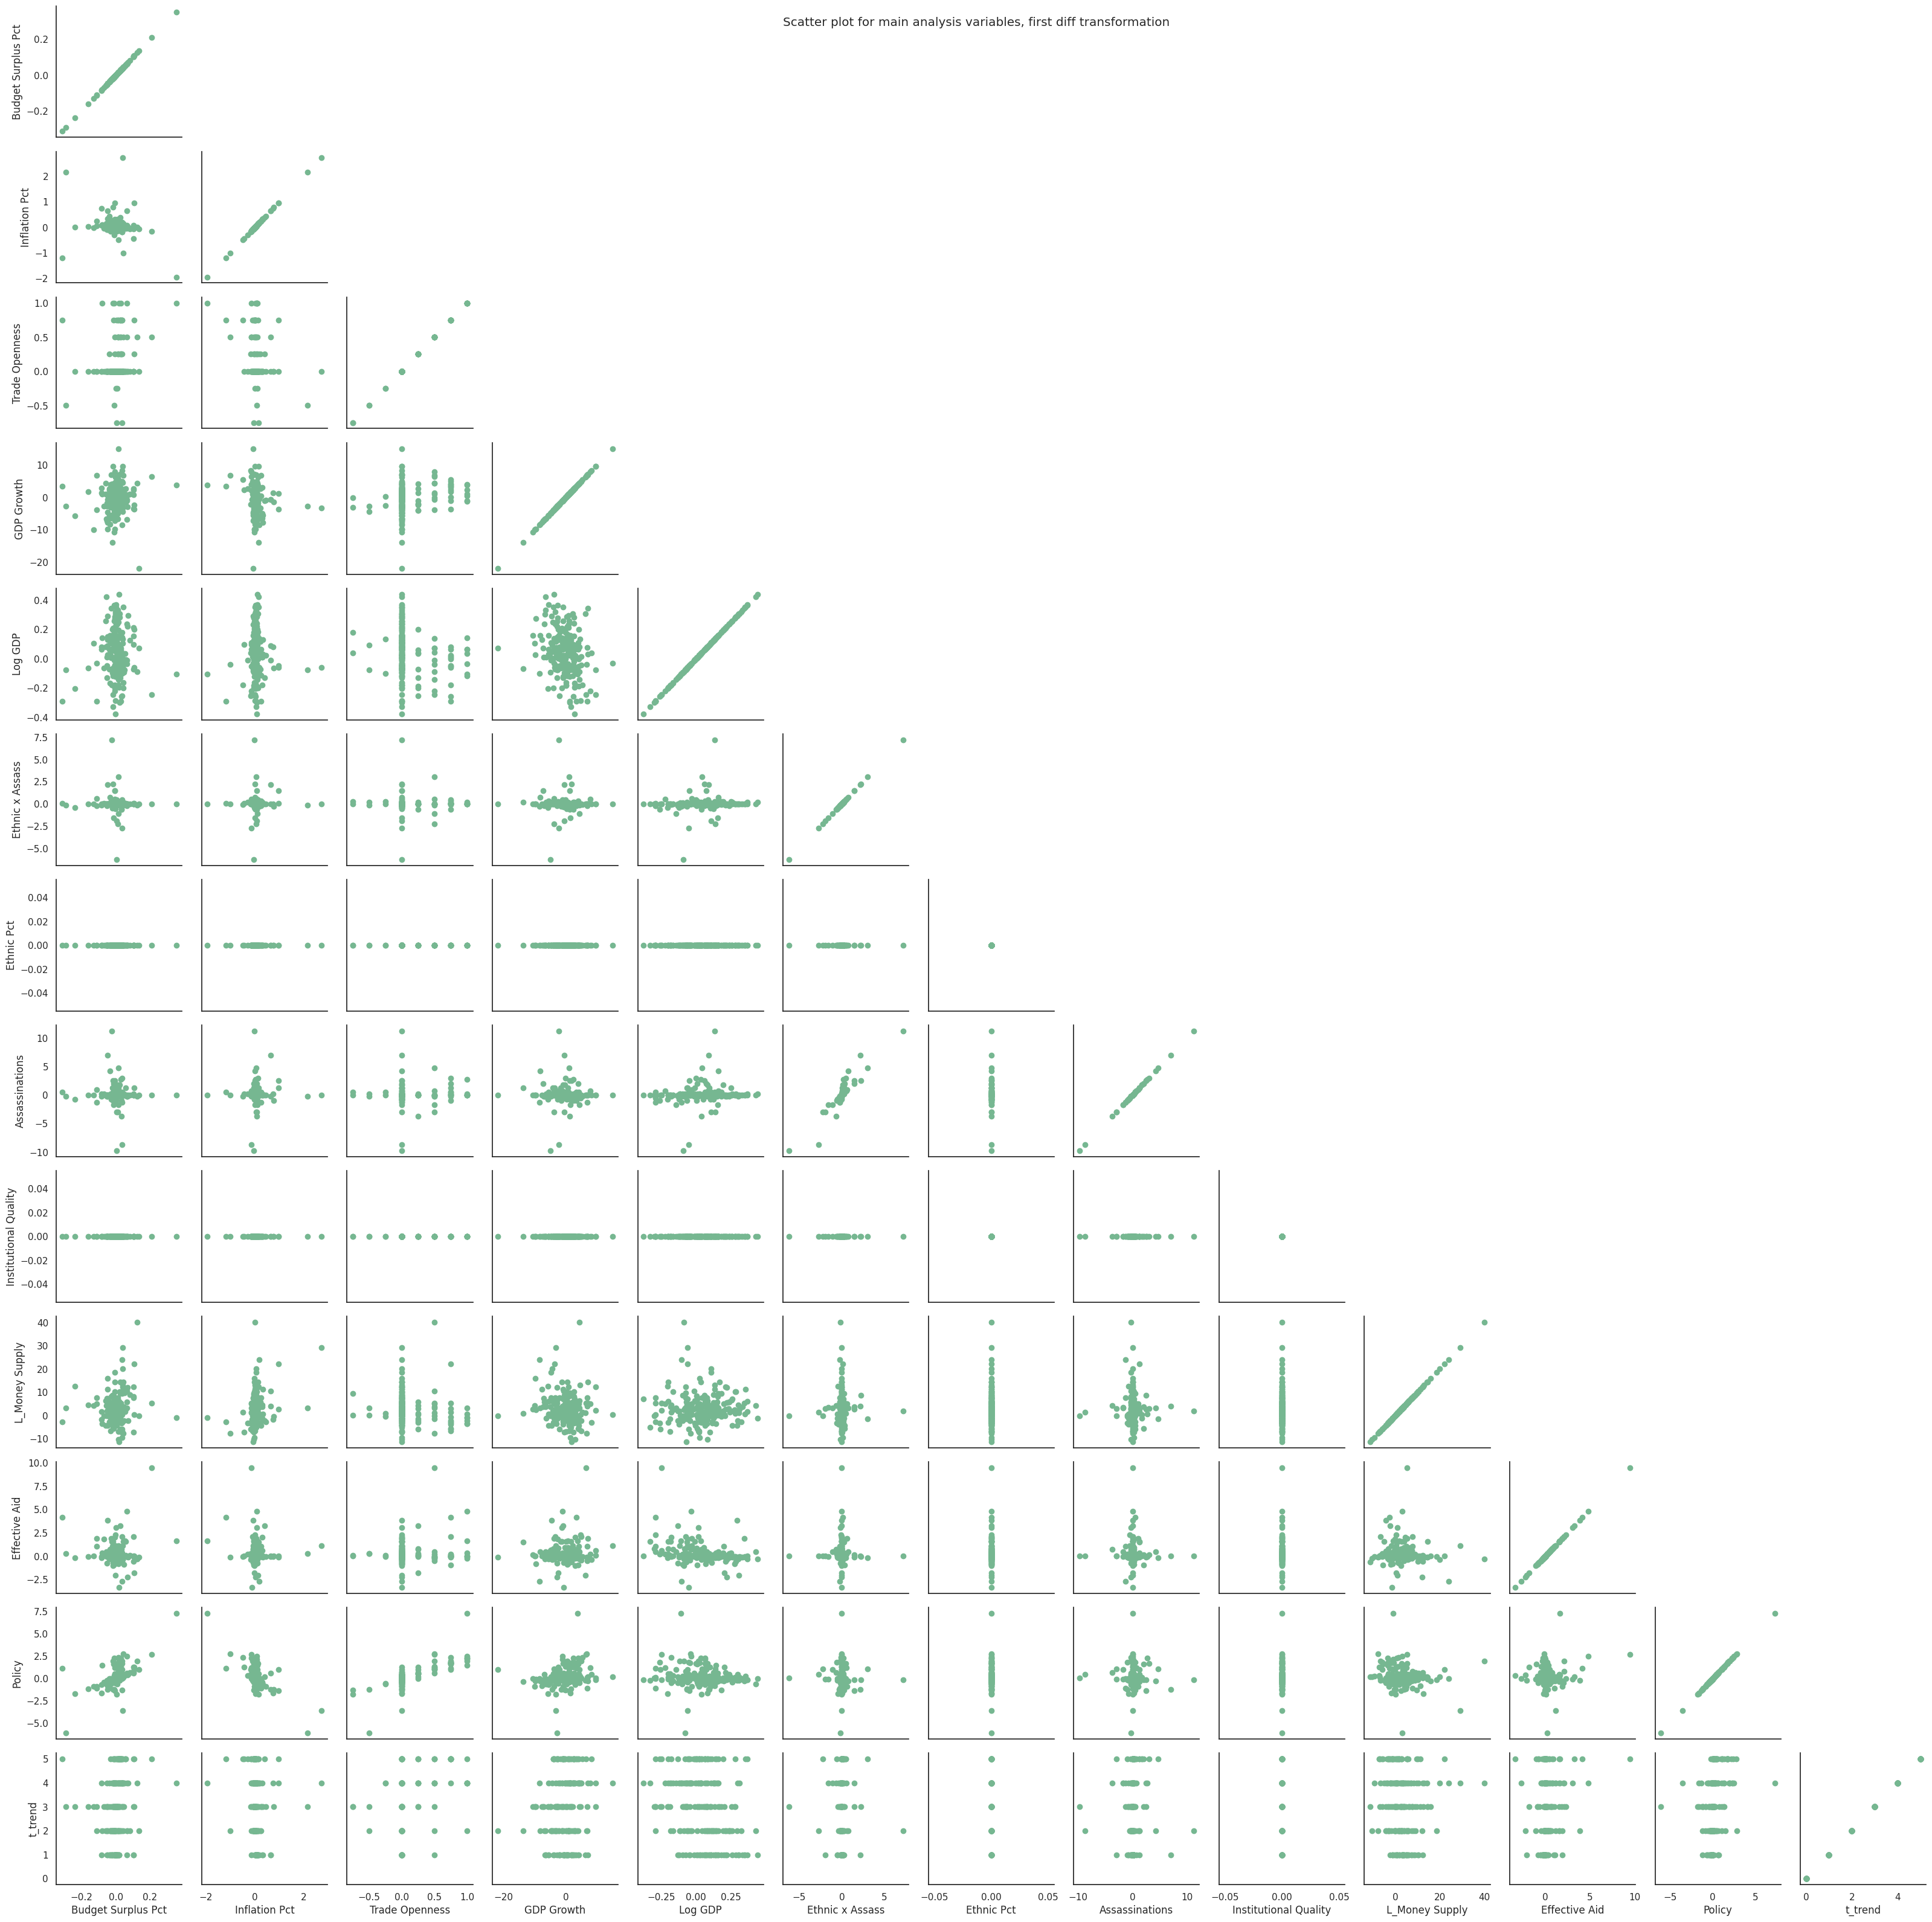

In [ ]:
g = sns.PairGrid(firstdiff, corner=True)
g.map(plt.scatter);
g.fig.suptitle('Scatter plot for main analysis variables, first diff transformation', y= plt.savefig("Graph21.png",bbox_inches="tight"))
plt.show()

12.	*Comment the bivariate graphs with linear, quadratic and Lowess fit for dependent and key explanatory variable (aid/gdp and growth of gdp): Within transformed, Between transformed, First differences, two-way-within transformed.*


For within, effective aid seems to have a positive relationship with GDP Growth in the quadratic model (in part shaped by outliers). The linear model shows no relationship.

For between, effective aid initially harms GDP growth before boosting it at high levels (in the quadratic model). Again, it appears to be shaped by outliers. The linear model shows no such relationship.

Theoretically, it does not make sense for zero or negative aid to have a positive impact, some aid to have a negative one, and for a lot of aid to have a lot of positive impact. The quadratic models are poor fits and do not fit our theoretical basis.

---
The first differences and two-way-within transformed graphs tell a different story. Both show (in all models) that effective aid has a slight positive relationship with GDP growth that is roughly linear.

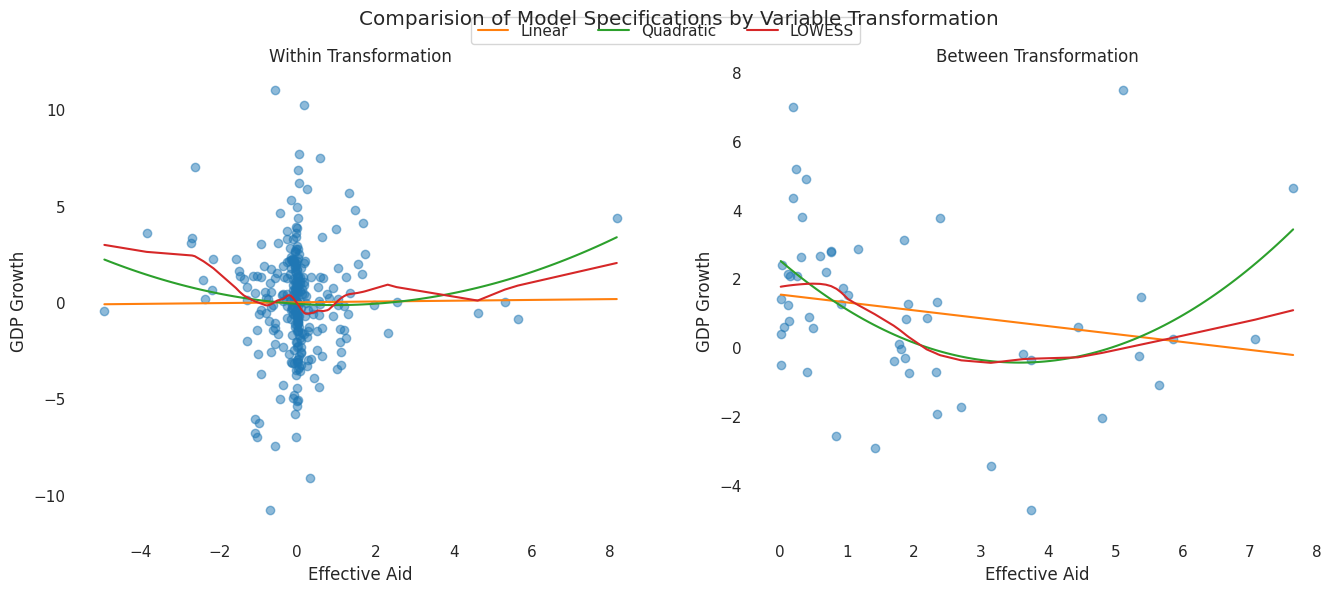

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,6), dpi=100)
transforms = [within, between]
cmap = cm.get_cmap('tab10')
gradient = cmap(np.linspace(0,1,10))

for axis, transform in zip(fig.axes, transforms):
  if transform is within: title = 'Within Transformation'
  else: title = 'Between Transformation'

  x = transform['Effective Aid']
  y = transform['GDP Growth']

  xl_1, xl_0 = np.polyfit(x, y, 1, full=False)
  xq_2, xq_1, xq_0 = np.polyfit(x, y, 2, full=False)

  xl = [min(x), max(x)]
  yl = [xx * xl_1 + xl_0 for xx in xl]

  xq = np.linspace(min(x), max(x), 100)
  yq = [xx**2*xq_2 + xx*xq_1 + xq_0 for xx in xq]

  lowess = sm.nonparametric.lowess(y, x, frac=0.66)

  axis.scatter(x, y, alpha=0.5, color=gradient[0].squeeze().tolist())
  axis.plot(xl, yl, color=gradient[1].squeeze().tolist(), label='Linear')
  axis.plot(xq, yq, color=gradient[2].squeeze().tolist(), label='Quadratic')
  axis.plot(lowess[:,0], lowess[:,1], color=gradient[3].squeeze().tolist(), label='LOWESS')

  for spine in axis.spines.values():
    spine.set_visible(False)
  axis.tick_params(which='both', axis='both', left=False, right=False, top=False, bottom=False)
  axis.set_title(title)
  axis.set_xlabel('Effective Aid')
  axis.set_ylabel('GDP Growth')

ax[0].legend(ncol=3, bbox_to_anchor=(1.4,1.13))
fig.suptitle('Comparision of Model Specifications by Variable Transformation')
plt.show()

In [ ]:
overall_mean = df.mean()
country_means = df.groupby('country').transform("mean")
time_means = df.groupby('year1').transform('mean')

TWFE = df - country_means - time_means + overall_mean

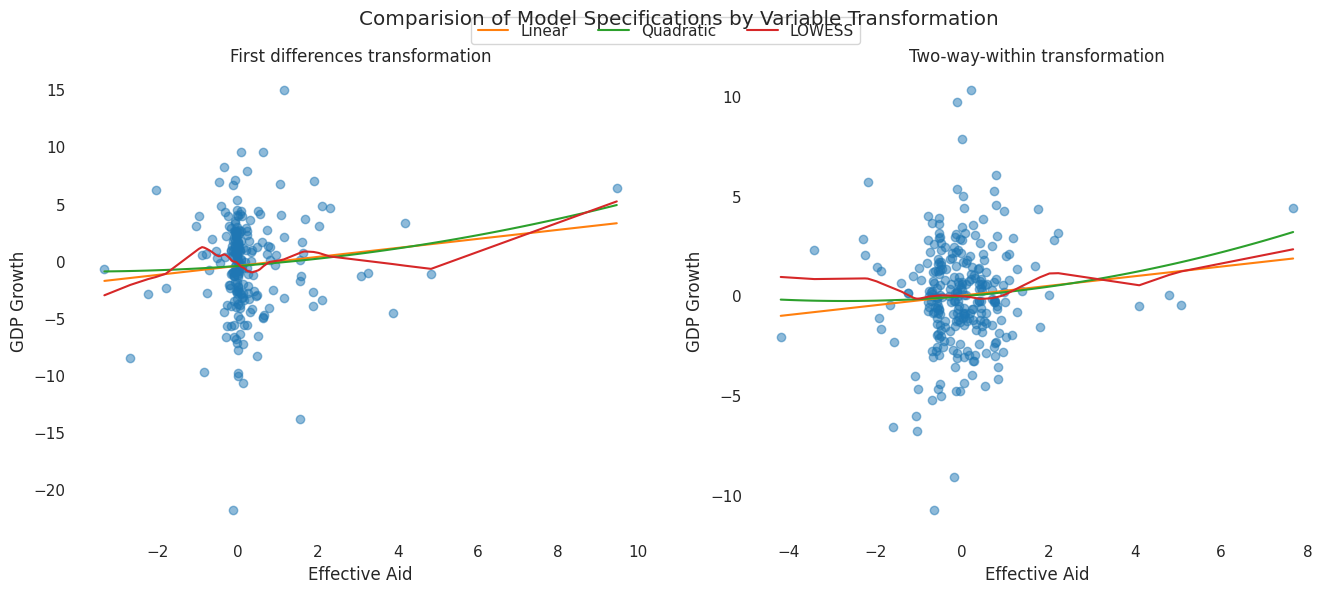

In [ ]:
p = 0

fig, ax = plt.subplots(1,2, figsize=(16,6), dpi=100)
transforms = [firstdiff.dropna(), TWFE]
cmap = cm.get_cmap('tab10')
gradient = cmap(np.linspace(0,1,10))

for axis, transform in zip(fig.axes, transforms):

  if p==0:
    title = 'First differences transformation'
    p = p+1
  else: title = 'Two-way-within transformation'

  x = transform['Effective Aid']
  y = transform['GDP Growth']

  xl_1, xl_0 = np.polyfit(x, y, 1, full=False)
  xq_2, xq_1, xq_0 = np.polyfit(x, y, 2, full=False)

  xl = [min(x), max(x)]
  yl = [xx * xl_1 + xl_0 for xx in xl]

  xq = np.linspace(min(x), max(x), 100)
  yq = [xx**2*xq_2 + xx*xq_1 + xq_0 for xx in xq]

  lowess = sm.nonparametric.lowess(y, x, frac=0.66)

  axis.scatter(x, y, alpha=0.5, color=gradient[0].squeeze().tolist())
  axis.plot(xl, yl, color=gradient[1].squeeze().tolist(), label='Linear')
  axis.plot(xq, yq, color=gradient[2].squeeze().tolist(), label='Quadratic')
  axis.plot(lowess[:,0], lowess[:,1], color=gradient[3].squeeze().tolist(), label='LOWESS')

  for spine in axis.spines.values():
    spine.set_visible(False)
  axis.tick_params(which='both', axis='both', left=False, right=False, top=False, bottom=False)
  axis.set_title(title)
  axis.set_xlabel('Effective Aid')
  axis.set_ylabel('GDP Growth')

ax[0].legend(ncol=3, bbox_to_anchor=(1.4,1.13))
fig.suptitle('Comparision of Model Specifications by Variable Transformation')
plt.show()

13.	*Comment the results of estimations of Between, Within (one-way fixed effects, (fe)) and Mundlak (random effects (re) including all X(i.) as regressors), two-way fixed effects (add year dummies in fe regression) and First differences, including all explanatory variables except the ones with high near-multicollinearity in their respective between or within space.*


The Between estimation shows policy as the only significant driver of GDP growth. While the R^2 is very high, the number of parameters (especially dummies for region) lead to overfitting. The residuals show an even distribution about the origin. The lack of outliers confirms the overfitting (we know that our data has outliers from the previous sections).

---

For Within, Ethnic x Assass and Log GDP join Policy as significant. The R^2 is about what we expect at 0.160. Policy has a strong positive sign and so does Ethnic x Assass. Log GDP has a negative coefficient, telling us that larger economies grow slower. This is not necessarily true for developing countries. The residuals have more outliers, which makes more sense for our data. Although the coefficients may be skewed due to correlation between variables and omitted variable bias, we suspect that the end result is not overfitted.

---

For Mundlak, the r^2 is 0.3971. Every time period's dummy variable is significant. The y-hat distibution is platykurtic. This suggests that the time period's are capturing a common trend for that time period however the errors are not normal between the countries. Looking at the other coefficients, the time period dummy variables is "swallowing" a lot of the variation that normally is described by the exogenous variables.

---

For two-way fixed effects (2WFE), the r^2 is 0.1017. Only Policy, Assassinations, and Ethnic x Assassinations are significant. This is a poor fit for our data and it does not make sense that the policy index and the murder rate are the largest driver of GDP growth when some of the other exogenous variables have been seen as good explainers elsewhere.

---

And finally for first differences, the r^2 is 0.1313. The distribution of the residuals is normal. However, the only significiant coefficients are the policy index and log GDP. That is unusual considering our findings elsewhere that there are relationships between the other variables and GDP growth.

In [ ]:
exog_vars = ['Log GDP', 'Ethnic x Assass',
          'Ethnic Pct', 'Assassinations','Institutional Quality', 'L_Money Supply', 'Effective Aid', 'Policy',
             'East Asia', 'Egypt', 'Sub-Saharan Africa', 'Central America']

In [ ]:
pd.set_option("display.max_columns", 60)

In [ ]:
df["year1"]= df.swaplevel().index.get_level_values("year1")
df.loc[df["year1"] =="1970-1973","year1"] =0
df.loc[df["year1"] =="1974-1977","year1"] =1
df.loc[df["year1"] =="1978-1981","year1"] =2
df.loc[df["year1"] =="1982-1985","year1"] =3
df.loc[df["year1"] =="1986-1989","year1"] =4
df.loc[df["year1"] =="1990-1993","year1"] =5
df["year1"]= df["year1"].astype(int)

df

index   ident  year countryyear country3  year11  \
country   year1                                                           
Algeria   1970-1973    9.000   2.000 2.000        DZA2      DZA   8.000   
          1974-1977   10.000   2.000 3.000        DZA3      DZA   1.000   
Argentina 1970-1973   30.000   5.000 2.000        ARG2      ARG   2.000   
          1974-1977   31.000   5.000 3.000        ARG3      ARG   3.000   
          1978-1981   32.000   5.000 4.000        ARG4      ARG   4.000   
...                      ...     ...   ...         ...      ...     ...   
Zambia    1986-1989 1224.000 175.000 6.000        ZMB6      ZMB   8.000   
          1990-1993 1225.000 175.000 7.000        ZMB7      ZMB   1.000   
Zimbabwe  1982-1985 1230.000 176.000 5.000        ZWE5      ZWE   6.000   
          1986-1989 1231.000 176.000 6.000        ZWE6      ZWE   7.000   
          1990-1993 1232.000 176.000 7.000        ZWE7      ZWE   8.000   

                     GDP Growth      gdp  Budget Surplus  Inflation  \
country   year1                                                       
Algeria   1970-1973       2.386 1826.000          -6.834      4.641   
          1974-1977       3.237 2256.000           3.660      8.209   
Argentina 1970-1973       1.700 5637.000          -2.115     34.089   
          1974-1977       1.078 6168.000          -6.912     98.996   
          1978-1981      -1.115 5849.000          -3.395     84.483   
...                         ...      ...             ...        ...   
Zambia    1986-1989      -1.568  786.000         -13.185     51.024   
          1990-1993      -2.580  689.000         -10.589     89.593   
Zimbabwe  1982-1985      -0.634 1332.000          -8.468     14.353   
          1986-1989       0.539 1178.000          -8.860     11.105   
          1990-1993      -2.015 1182.000          -6.752     24.116   

                     Trade Openness   govc  Ethnic Frac  Assassinations  \
country   year1                                                           
Algeria   1970-1973           0.000 15.472       43.000           0.000   
          1974-1977           0.000 12.345       43.000           0.000   
Argentina 1970-1973           0.000 10.195       31.000           2.750   
          1974-1977           0.000 11.044       31.000           9.750   
          1978-1981           0.000 11.087       31.000           1.000   
...                             ...    ...          ...             ...   
Zambia    1986-1989           0.000 18.962       82.000           0.000   
          1990-1993           0.250 18.837       82.000           0.000   
Zimbabwe  1982-1985           0.000 20.228       54.000           0.750   
          1986-1989           0.000 24.476       54.000           0.000   
          1990-1993           0.000 21.711       54.000           0.000   

                     Institutional Quality  L_Money Supply  \
country   year1                                              
Algeria   1970-1973                  4.365          49.103   
          1974-1977                  4.365          61.462   
Argentina 1970-1973                  4.281          24.825   
          1974-1977                  4.281          28.793   
          1978-1981                  4.281          30.235   
...                                    ...             ...   
Zambia    1986-1989                  4.136          33.867   
          1990-1993                  4.136          31.673   
Zimbabwe  1982-1985                  4.438          33.404   
          1986-1989                  4.438          29.761   
          1990-1993                  4.438          30.280   

                     Sub-Saharan Africa  East Asia  Log Population  Egypt  \
country   year1                                                             
Algeria   1970-1973               0.000      0.000          16.483  0.000   
          1974-1977               0.000      0.000          16.606  0.000   
Argentina 1970-1973             

In [ ]:
_df = df.reset_index(allow_duplicates=True).set_index(['country', 'year'])

_df['Clusters'] = list(map(lambda x: np.sum([ord(xx) for xx in x]), _df.index.get_level_values(0)))

y = _df['GDP Growth']
x = _df[exog_vars]

model = lm.BetweenOLS(y, sm.add_constant(x), check_rank=False).fit(cov_type='clustered', clusters= _df['Clusters'])
between_results = save_results(model, 'Between')
model.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                         BetweenOLS Estimation Summary                          
================================================================================
Dep. Variable:             GDP Growth   R-squared:                        0.6491
Estimator:                 BetweenOLS   R-squared (Between):              0.6491
No. Observations:                  56   R-squared (Within):              -0.0205
Date:                Mon, Jan 29 2024   R-squared (Overall):              0.2282
Time:                        22:39:24   Log-likelihood                   -98.294
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.6294
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                   F(12,43)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             43.316
                                        P-value                           0.0000
Time periods:                       6   Distribution:                   F(12,43)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
const                    -3.6339     5.1625    -0.7039     0.4853     -14.045      6.7773
Log GDP                   0.2464     0.7190     0.3428     0.7335     -1.2036      1.6965
Ethnic x Assass           0.5760     0.7196     0.8004     0.4279     -0.8753      2.0272
Ethnic Pct               -0.0138     1.1971    -0.0115     0.9908     -2.4279      2.4003
Assassinations           -0.1700     0.2980    -0.5704     0.5714     -0.7710      0.4310
Institutional Quality     0.2314     0.2655     0.8716     0.3883     -0.3040      0.7669
L_Money Supply            0.0017     0.0258     0.0668     0.9471     -0.0502      0.0537
Effective Aid             0.2379     0.2222     1.0706     0.2903     -0.2102      0.6860
Policy                    1.6556     0.3552     4.6607     0.0000      0.9392      2.3720
East Asia                 0.2039     0.8332     0.2448     0.8078     -1.4763      1.8842
Egypt                     3.3341     1.0614     3.1411     0.0030      1.1935      5.4747
Sub-Saharan Africa       -1.5234     0.9482    -1.6066     0.1155     -3.4355      0.3888
Central America          -1.3238     0.4677    -2.8303     0.0070     -2.2671     -0.3806
=========================================================================================
"""

In [ ]:
restricted = lm.BetweenOLS(y, sm.add_constant(_df['Policy'])).fit(cov_type='clustered', clusters=_df['Clusters'])

q = len(exog_vars) - 4
n = _df.shape[0]
k = len(exog_vars)

SSR_R = restricted.resid_ss
SSR_UR = model.resid_ss

F = ((SSR_R - SSR_UR) / q) / ((SSR_UR)/(n-k-1))

print('F-test of equivilant variance')
print('H0: Var(Restricted) = Var(Unrestricted)')
print(f'df1 = {q}, df2={n-k-1}')
print('='*40)
print(f'F-stat = {F:0.03f}')
print(f'p = {stats.f.sf(F, q, n-k-1):0.3f}')

F-test of equivilant variance
H0: Var(Restricted) = Var(Unrestricted)
df1 = 8, df2=262
F-stat = 12.513
p = 0.000


In [ ]:
def resid_plot(x, model, title, transform, resids=None, y_hat=None, labels_x = False, labels_y = False, outlier_x=None, outlier_y=None, color_col=None):
    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

    cmap = cm.get_cmap('tab20')
    gradient = cmap(np.linspace(0,1,10))

    if transform == 'between':
        X = x.groupby('country').agg(np.mean).values
    else: X = x.values.squeeze()

    H = X @ np.linalg.inv(X.T @ X) @ X.T

    if isinstance(model, sm.regression.linear_model.RegressionResultsWrapper):
        student_resid = model.resid.values / (model.resid.std() * np.sqrt(1 - np.diag(H)))
    elif model is None:
        student_resid = resids.values / (resids.std() * np.sqrt(1 - np.diag(H)))
    else:
        student_resid = model.resids.values / (model.resids.std() * np.sqrt(1 - np.diag(H)))

    if transform == 'between':
        avg_y_hat = model.predict(x).groupby('country').agg(np.mean)
    elif model is None:
        avg_y_hat = y_hat.to_frame()
        avg_y_hat.columns = ['predictions']
    else:
        avg_y_hat = model.predict(x)

    if isinstance(model, sm.regression.linear_model.RegressionResultsWrapper):
        avg_y_hat = avg_y_hat.to_frame()
        avg_y_hat.columns = ['predictions']

    mean_resid = student_resid.mean()
    std_resid = student_resid.std()
    skew_resid = stats.skew(student_resid)
    kur_resid = stats.kurtosis(student_resid, fisher=False)

    mean_yhat = avg_y_hat['predictions'].mean()
    std_yhat = avg_y_hat['predictions'].std()
    skew_yhat = stats.skew(avg_y_hat['predictions'])
    kur_yhat = stats.kurtosis(avg_y_hat['predictions'], fisher=False)

    gs = GridSpec(4, 4)
    fig = plt.figure(figsize=(8,6), dpi=100)

    ax_main = fig.add_subplot(gs[1:4, 0:3])
    ax_x = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
    ax_y = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

    if color_col is not None:
        color_by = color_col.name
        y_hat_plus = pd.merge(avg_y_hat, color_col, left_index=True, right_index=True)
        y_hat_plus['resids'] = student_resid
        _temp_df = y_hat_plus.groupby(color_by)
        for i, group in enumerate(_temp_df.groups.keys()):
            yy = _temp_df.get_group(group)['predictions'].values.squeeze()
            xx = _temp_df.get_group(group)['resids'].values.squeeze()
            ax_main.scatter(yy, xx, alpha=0.6, zorder=2, color=gradient[i], label=group)

        ax_main.legend(fontsize=8)

    else:
        ax_main.scatter(avg_y_hat, student_resid, alpha=0.6, zorder=2)

    sns.kdeplot(avg_y_hat['predictions'], shade=True, ax=ax_x, legend=False, zorder=2)
    sns.kdeplot(student_resid, shade=True, ax=ax_y, vertical=True, zorder=2)
    ax_main.set_xlabel('$\hat{y}_{i,.}$')
    ax_main.set_ylabel('Studentized Residuals')

    for xx, yy, name in zip(avg_y_hat['predictions'], student_resid, df.index):
        if labels_x == True and labels_y == False:
            if (xx < outlier_x[0] or xx > outlier_x[1]):
                text = re.findall("(?<=\')(\w+\W? ?\w*\W? ?\w*)(?=\')",str(name))
                s = text[0] + '\n' + text[-1]
                ax_main.text(xx,yy,s, size=5)

        elif labels_x == False and labels_y == True:
            if (yy > outlier_y[1]) or (yy < outlier_y[0]):
                text = re.findall("(?<=\')(\w+\W? ?\w*\W? ?\w*)(?=\')",str(name))
                s = text[0] + '\n' + text[-1]
                ax_main.text(xx,yy,s, size=5)

        elif labels_x == True and labels_y == True:
            if (xx < outlier_x[0] or xx > outlier_x[1]) or (yy > outlier_y[1] or yy < outlier_y[0]):
                text = re.findall("(?<=\')(\w+\W? ?\w*\W? ?\w*)(?=\')",str(name))
                s = text[0] + '\n' + text[-1]
                ax_main.text(xx,yy,s, size=5)

    for axis in fig.axes:
        for spine in axis.spines.values():
            spine.set_visible(False)

        axis.tick_params(which='both',
                      axis='both',
                      left=False,
                      right=False,
                      top=False,
                      bottom=False)
        axis.set_facecolor('ghostwhite')
        axis.grid(True, color='white', zorder=1, lw=2)

    plt.setp(ax_x.get_xticklabels(), visible=False)
    plt.setp(ax_x.get_yticklabels(), visible=False)
    plt.setp(ax_y.get_xticklabels(), visible=False)
    plt.setp(ax_y.get_yticklabels(), visible=False)

    left_corner_x = ax_x.get_xlim()[0]
    left_corner_y = ax_x.get_ylim()[1]
    u_y = (ax_x.get_ylim()[1] - ax_x.get_ylim()[0]) / 100
    u_x = (ax_x.get_xlim()[1] - ax_x.get_xlim()[0]) / 100

    for i, (name, value) in enumerate(zip(['μ', 'σ', 'skew', 'kurtosis'], [mean_yhat, std_yhat, skew_yhat, kur_yhat])):
        ax_x.text(0.95 * left_corner_x, 0.9*left_corner_y-(u_y * (12*i)), s=f'{name}={value:0.2f}', fontsize=8)

    right_corner_x = ax_y.get_xlim()[1]
    right_corner_y = ax_y.get_ylim()[1]
    u_y = (ax_y.get_ylim()[1] - ax_y.get_ylim()[0]) / 100
    u_x = (ax_y.get_xlim()[1] - ax_y.get_xlim()[0]) / 100

    for i, (name, value) in enumerate(zip(['μ', 'σ', 'skew', 'kurtosis'], [mean_resid, std_resid, skew_resid, kur_resid])):
        ax_y.text(0.5*right_corner_x, 0.9*right_corner_y - (u_y * (4*i)), s=f'{name}={value:0.2f}', fontsize=8)

    plt.tight_layout()
    fig.suptitle('Studentized Residuals and Predicted Average $\hat{y}_{i,.}$, with Distributions \n' +  f'{title}',
                 y=1.065, size=14, fontweight='semibold')
    plt.show()

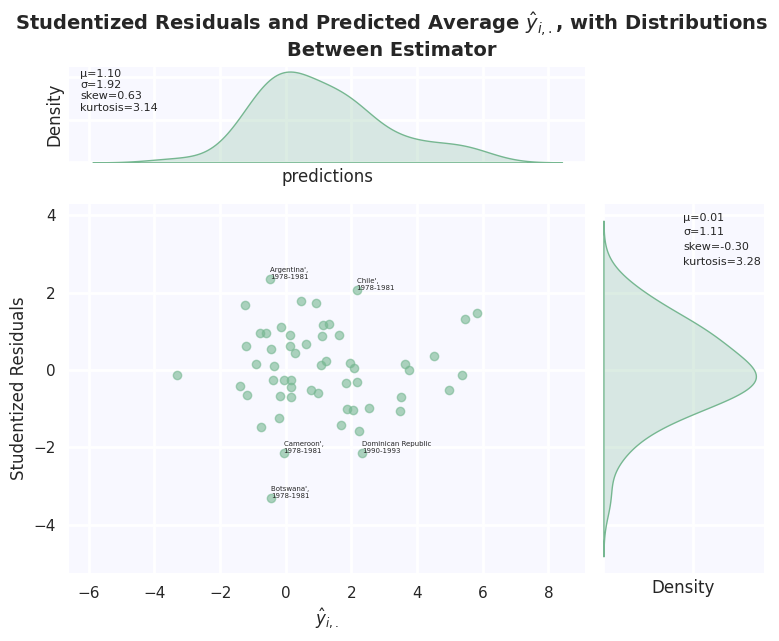

In [ ]:
resid_plot(x = sm.add_constant(x), model=model, title='Between Estimator',
           transform='between', labels_y=True, outlier_y=(-2, 2))

In [ ]:
Exog_vars_within = set(exog_vars) - set(['Institutional Quality','East Asia', 'Egypt', 'Sub-Saharan Africa', 'Central America'])

x = _df[Exog_vars_within]
within_fe = lm.PanelOLS(y, x, entity_effects=True, time_effects=False, drop_absorbed=True).fit(cov_type='clustered', clusters=_df['Clusters'])
fe_results = save_results(within_fe, 'Fixed Effects')
within_fe.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:             GDP Growth   R-squared:                        0.1602
Estimator:                   PanelOLS   R-squared (Between):             -149.88
No. Observations:                 275   R-squared (Within):               0.1602
Date:                Mon, Jan 29 2024   R-squared (Overall):             -72.574
Time:                        22:39:26   Log-likelihood                   -653.88
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.7737
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                   F(6,213)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             9.5741
                                        P-value                           0.0000
Time periods:                       6   Distribution:                   F(6,213)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
L_Money Supply     -0.0417     0.0249    -1.6769     0.0950     -0.0907      0.0073
Log GDP            -4.0686     1.4016    -2.9029     0.0041     -6.8314     -1.3059
Assassinations     -0.5371     0.3384    -1.5873     0.1139     -1.2040      0.1299
Policy              0.9289     0.1678     5.5370     0.0000      0.5982      1.2596
Effective Aid      -0.1227     0.1838    -0.6674     0.5052     -0.4850      0.2397
Ethnic x Assass     1.0519     0.4864     2.1628     0.0317      0.0932      2.0107
===================================================================================

F-test for Poolability: 1.7902
P-value: 0.0018
Distribution: F(55,213)

Included effects: Entity
"""

In [ ]:
within_fete = lm.PanelOLS(y, x, entity_effects=True, time_effects=True, drop_absorbed=True).fit(cov_type='clustered', clusters=_df['Clusters'])
fete_results = save_results(within_fete, 'Fixed/Time Effects')
within_fete.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:             GDP Growth   R-squared:                        0.1017
Estimator:                   PanelOLS   R-squared (Between):             -38.190
No. Observations:                 275   R-squared (Within):               0.1159
Date:                Mon, Jan 29 2024   R-squared (Overall):             -18.671
Time:                        22:39:26   Log-likelihood                   -633.25
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.9248
Entities:                          56   P-value                           0.0010
Avg Obs:                       4.9107   Distribution:                   F(6,208)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             4.1897
                                        P-value                           0.0005
Time periods:                       6   Distribution:                   F(6,208)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
L_Money Supply      0.0015     0.0297     0.0490     0.9609     -0.0571      0.0600
Log GDP            -2.1733     1.5302    -1.4203     0.1570     -5.1900      0.8433
Assassinations     -0.6544     0.2653    -2.4667     0.0144     -1.1774     -0.1314
Policy              0.8400     0.2145     3.9168     0.0001      0.4172      1.2628
Effective Aid       0.1416     0.2019     0.7013     0.4839     -0.2565      0.5397
Ethnic x Assass     1.2619     0.4944     2.5522     0.0114      0.2871      2.2367
===================================================================================

F-test for Poolability: 2.4232
P-value: 0.0000
Distribution: F(60,208)

Included effects: Entity, Time
"""

In [ ]:
pd.merge(fe_results, fete_results, left_index=True, right_index=True)

Fixed Effects Fixed/Time Effects
L_Money Supply        -0.042*              0.001
Log GDP             -4.069***             -2.173
Assassinations         -0.537           -0.654**
Policy               0.929***           0.840***
Effective Aid          -0.123              0.142
Ethnic x Assass       1.052**            1.262**
r2                      0.160              0.102

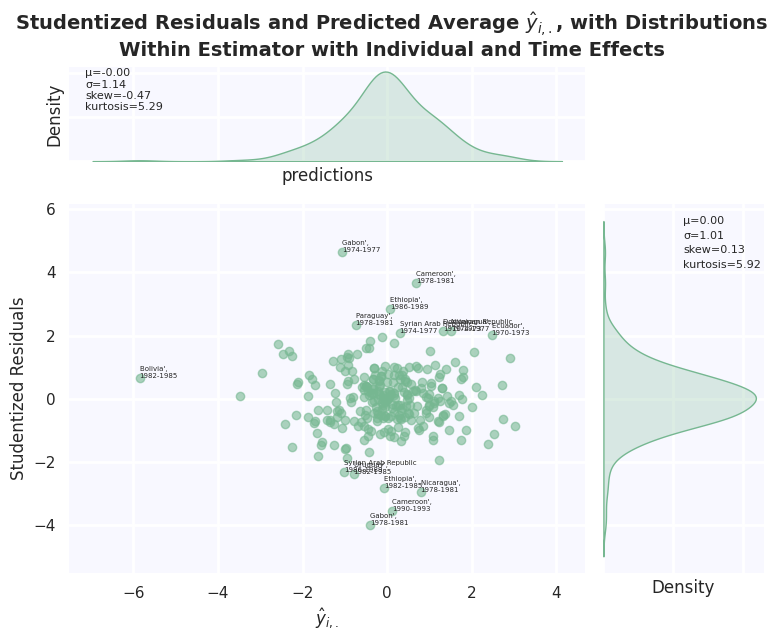

In [ ]:
within_x = x.groupby('country').apply(lambda x: x - x.mean())
resid_plot(within_x.drop(columns=['Ethnic Pct']),
           model=within_fe, title='Within Estimator with Individual and Time Effects',
           transform='within', labels_y=True, outlier_y=(-2,2),
          labels_x=True, outlier_x=(-5,5))

In [ ]:
def make_regions_var(dummy_frame):
    for col in dummy_frame.index:
        if dummy_frame[col] > 0:
            return col
    return 'Other'

region_dummies = _df[['East Asia', 'Egypt', 'Sub-Saharan Africa', 'Central America']].copy()
region_dummies = region_dummies.apply(make_regions_var, axis=1)
region_dummies.name = 'Region'

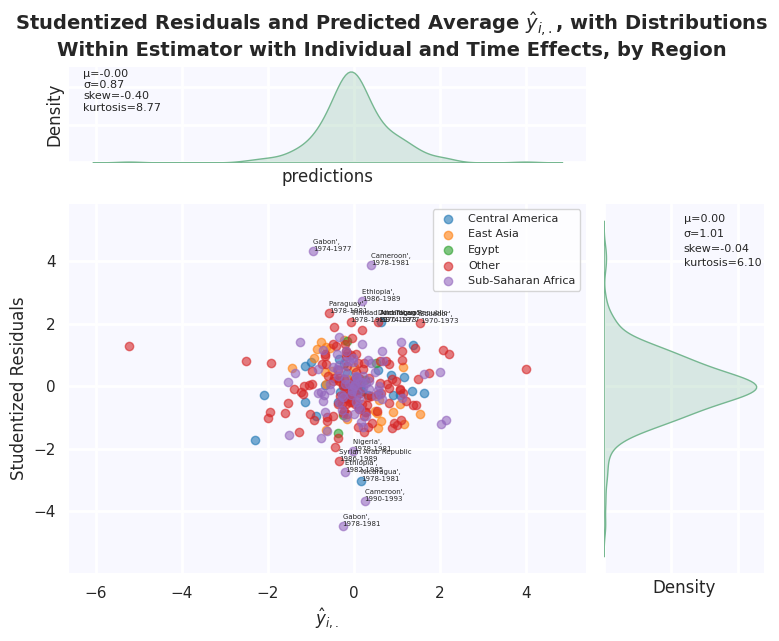

In [ ]:
resid_plot(within_x.drop(columns=['Ethnic Pct']), model=within_fete, transform='within', title='Within Estimator with Individual and Time Effects, by Region',
           labels_y=True, outlier_y=(-2,2), color_col = region_dummies)

In [ ]:
_df = df.reset_index(allow_duplicates=True).set_index(['country', 'year'])

_df['Clusters'] = list(map(lambda x: np.sum([ord(xx) for xx in x]), _df.index.get_level_values(0)))

y = _df['GDP Growth']
time_effects = ['year3', 'year4', 'year5', 'year6', 'year7']
x = sm.add_constant(_df[exog_vars + time_effects])
ref = lm.panel.RandomEffects(y, x).fit(small_sample=True, cov_type='clustered', clusters=_df['Clusters'])
re_results = save_results(ref, 'Random Effects')
ref.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                        RandomEffects Estimation Summary                        
================================================================================
Dep. Variable:             GDP Growth   R-squared:                        0.3806
Estimator:              RandomEffects   R-squared (Between):              0.5810
No. Observations:                 275   R-squared (Within):               0.2618
Date:                Mon, Jan 29 2024   R-squared (Overall):              0.4094
Time:                        22:39:29   Log-likelihood                   -662.63
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      9.2873
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                  F(17,257)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             38.334
                                        P-value                           0.0000
Time periods:                       6   Distribution:                  F(17,257)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
const                     2.9026     3.7388     0.7763     0.4383     -4.4600      10.265
Log GDP                  -0.4583     0.5085    -0.9013     0.3683     -1.4597      0.5430
Ethnic x Assass           0.9192     0.3466     2.6520     0.0085      0.2366      1.6017
Ethnic Pct               -0.3155     0.9072    -0.3477     0.7283     -2.1019      1.4710
Assassinations           -0.4548     0.1639    -2.7743     0.0059     -0.7777     -0.1320
Institutional Quality     0.5910     0.1947     3.0347     0.0027      0.2075      0.9745
L_Money Supply           -0.0030     0.0150    -0.1963     0.8445     -0.0326      0.0267
Effective Aid             0.1133     0.1642     0.6896     0.4910     -0.2102      0.4367
Policy                    1.0029     0.1824     5.4974     0.0000      0.6436      1.3621
East Asia                 0.9204     0.6656     1.3828     0.1679     -0.3903      2.2311
Egypt                     3.1986     0.6681     4.7873     0.0000      1.8828      4.5143
Sub-Saharan Africa       -1.8932     0.7379    -2.5658     0.0109     -3.3463     -0.4402
Central America          -0.9469     0.4743    -1.9964     0.0469     -1.8808     -0.0129
year3                    -0.0358     0.4665    -0.0766     0.9390     -0.9544      0.8829
year4                    -1.4299     0.7272    -1.9664     0.0503     -2.8618      0.0021
year5                    -3.3763     0.5558    -6.0749     0.0000     -4.4707     -2.2818
year6                    -1.9567     0.5298    -3.6931     0.0003     -3.0001     -0.9133
year7                    -2.3534     0.6153    -3.8248     0.0002     -3.5651     -1.1417
=========================================================================================
"""

In [ ]:
x = _df[Exog_vars_within]
ref = lm.panel.RandomEffects(y, x.drop(columns=['Ethnic Pct'])).fit()

β_re = ref.params.values.squeeze()
β_fe = within_fete.params.values.squeeze()

H = (β_fe - β_re).T @ np.linalg.inv(within_fete.cov.values - ref.cov.values) @ (β_fe - β_re)
print('Hausman Test of Endogeneity')
print('H0: No Endogeneity in RE model (E[c_i | X] = 0)')
print('='*30)
print(f'H = {H:0.4f}, df = {x.shape[1]}')
print(f'p = {stats.chi2.sf(H, x.shape[1]):0.05f}')

Hausman Test of Endogeneity
H0: No Endogeneity in RE model (E[c_i | X] = 0)
H = 23.1788, df = 7
p = 0.00159


In [ ]:
Exog_vars_no_dummies = list(set(exog_vars) - set(['Sub-Saharan Africa', 'East Asia','Central America', 'Egypt']))
x = pd.merge(_df[exog_vars + time_effects], between[Exog_vars_no_dummies],
             how='inner', left_index=True, right_index=True, suffixes=('', '_mean'))
x = sm.add_constant(x)

x.drop(columns=['Institutional Quality_mean'], inplace=True)
mundlak = lm.panel.RandomEffects(y, x.drop(columns=['Ethnic Pct'])).fit(small_sample=False, cov_type='clustered',clusters=_df['Clusters'])
mundlak_results = save_results(mundlak, 'Mundlak')
mundlak.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                        RandomEffects Estimation Summary                        
================================================================================
Dep. Variable:             GDP Growth   R-squared:                        0.3971
Estimator:              RandomEffects   R-squared (Between):              0.6347
No. Observations:                 275   R-squared (Within):               0.2765
Date:                Mon, Jan 29 2024   R-squared (Overall):              0.4291
Time:                        22:39:29   Log-likelihood                   -657.28
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.1879
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                  F(23,251)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             53.246
                                        P-value                           0.0000
Time periods:                       6   Distribution:                  F(23,251)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
const                     0.5468     3.8182     0.1432     0.8862     -6.9730      8.0666
Log GDP                  -2.2828     1.3932    -1.6385     0.1026     -5.0266      0.4610
Ethnic x Assass           1.2678     0.4480     2.8297     0.0050      0.3854      2.1502
Assassinations           -0.6570     0.2433    -2.7008     0.0074     -1.1361     -0.1779
Institutional Quality     0.4209     0.2102     2.0019     0.0464      0.0068      0.8349
L_Money Supply           -0.0037     0.0260    -0.1420     0.8872     -0.0550      0.0476
Effective Aid             0.1173     0.1866     0.6288     0.5300     -0.2501      0.4848
Policy                    0.8178     0.1917     4.2670     0.0000      0.4404      1.1953
East Asia                 0.3290     0.7478     0.4400     0.6603     -1.1437      1.8017
Egypt                     3.2226     0.8570     3.7605     0.0002      1.5348      4.9104
Sub-Saharan Africa       -1.2144     0.8168    -1.4867     0.1384     -2.8231      0.3944
Central America          -1.0554     0.4248    -2.4847     0.0136     -1.8920     -0.2188
year3                     0.1989     0.4741     0.4196     0.6752     -0.7348      1.1326
year4                    -1.0580     0.7412    -1.4275     0.1547     -2.5177      0.4017
year5                    -3.1057     0.5903    -5.2613     0.0000     -4.2682     -1.9431
year6                    -1.6399     0.5512    -2.9753     0.0032     -2.7253     -0.5544
year7                    -1.8497     0.6220    -2.9739     0.0032     -3.0747     -0.6247
L_Money Supply_mean       0.0149     0.0351     0.4232     0.6725     -0.0543      0.0840
Log GDP_mean              2.0653     1.3789     1.4977     0.1355     -0.6505      4.7811
Ethnic Pct_mean          -0.1386     1.0714    -0.1294     0.8972     -2.2487      1.9715
Assassinations_mean       0.6159     0.3210     1.9187     0.0562     -0.0163      1.2481
Policy_mean               0.6035     0.4090     1.4758     0.1413     -0.2019      1.4090
Effective Aid_mean       -0.0989     0.1919    -0.5154     0.6068  

In [ ]:
from functools import reduce
#Remind ourselves what the FE model results were
to_merge = [fete_results, mundlak_results]
reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), to_merge)

Fixed/Time Effects    Mundlak
L_Money Supply               0.001     -0.004
Log GDP                     -2.173     -2.283
Assassinations            -0.654**  -0.657***
Policy                    0.840***   0.818***
Effective Aid                0.142      0.117
Ethnic x Assass            1.262**   1.268***
r2                           0.102      0.397

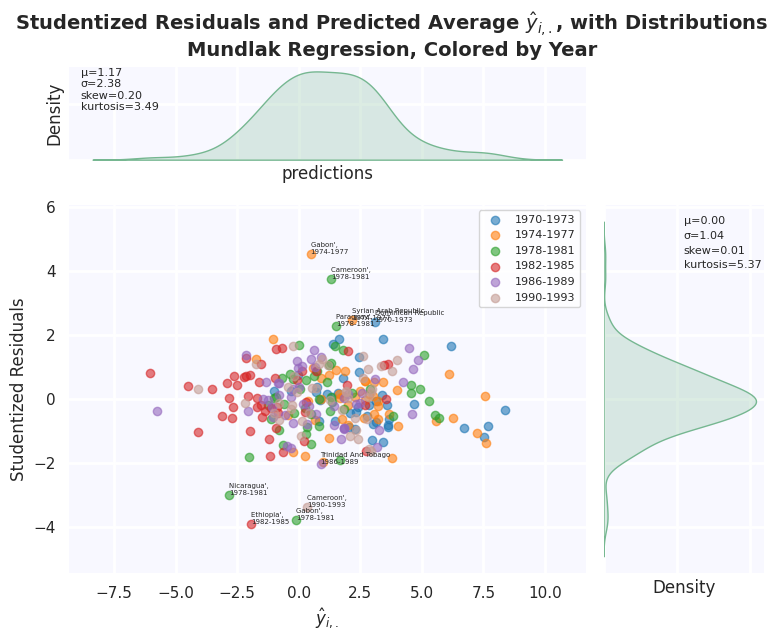

In [ ]:
resid_plot(x=x.drop(columns=['Ethnic Pct']), model=mundlak, title='Mundlak Regression, Colored by Year',
           labels_y=True, transform='Random', outlier_y=(-2,2),
           color_col=pd.Series(df.index.get_level_values(1), index=_df.index))

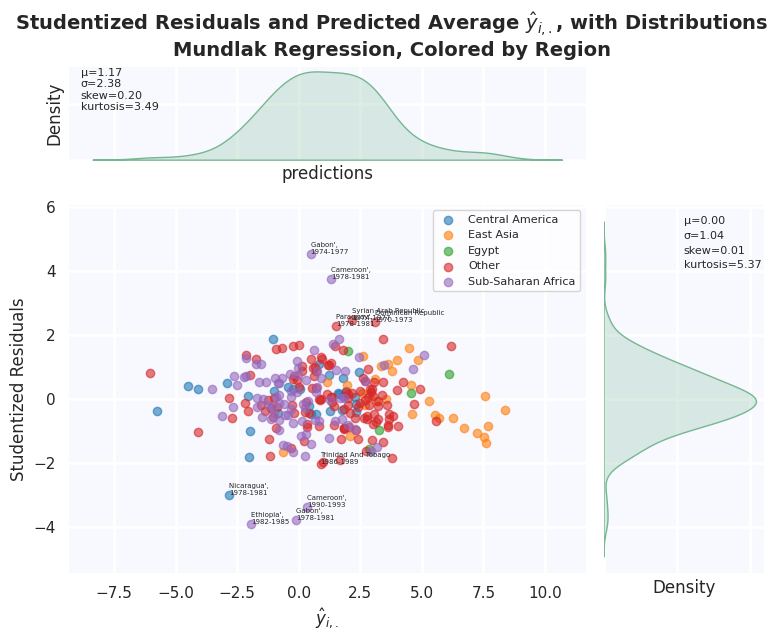

In [ ]:
resid_plot(x=x.drop(columns=['Ethnic Pct']), model=mundlak, title='Mundlak Regression, Colored by Region',
           labels_y=True, transform='Random', outlier_y=(-2,2),
           color_col=region_dummies
    )

In [ ]:
y = _df['GDP Growth']
x = _df[list(set(exog_vars) - set(['Institutional Quality', 'Ethnic Frac', 'Ethnic Pct', 'Sub-Saharan Africa', 'East Asia', 'Egypt', 'Central America']))]
diffOLS = lm.panel.FirstDifferenceOLS(y, x).fit(cov_type='clustered', clusters=_df['Clusters'])
diff_results = save_results(diffOLS, 'First Diff')
diffOLS.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                     FirstDifferenceOLS Estimation Summary                      
================================================================================
Dep. Variable:             GDP Growth   R-squared:                        0.1313
Estimator:         FirstDifferenceOLS   R-squared (Between):             -424.66
No. Observations:                 217   R-squared (Within):               0.1268
Date:                Mon, Jan 29 2024   R-squared (Overall):             -205.95
Time:                        22:39:31   Log-likelihood                   -600.90
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.3156
Entities:                          56   P-value                           0.0000
Avg Obs:                       4.9107   Distribution:                   F(6,211)
Min Obs:                       1.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.085
                                        P-value                           0.0000
Time periods:                       6   Distribution:                   F(6,211)
Avg Obs:                       45.833                                           
Min Obs:                       41.000                                           
Max Obs:                       49.000                                           
                                                                                
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
L_Money Supply     -0.0201     0.0249    -0.8061     0.4211     -0.0693      0.0291
Log GDP            -7.0632     1.3908    -5.0787     0.0000     -9.8047     -4.3216
Assassinations     -0.4268     0.4460    -0.9569     0.3397     -1.3060      0.4524
Policy              0.8688     0.2342     3.7101     0.0003      0.4072      1.3305
Effective Aid      -0.1202     0.1756    -0.6847     0.4943     -0.4663      0.2259
Ethnic x Assass     0.9176     0.6664     1.3770     0.1700     -0.3961      2.2313
===================================================================================
"""

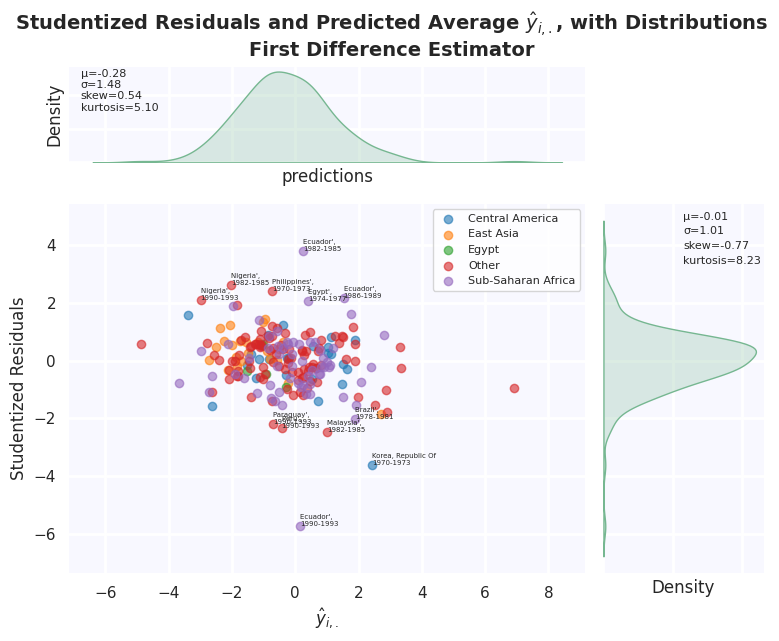

In [ ]:
diff_x = x.unstack(0).diff(1).stack().dropna().swaplevel().sort_values(by='country')
resid_plot(diff_x,
           diffOLS, title='First Difference Estimator', transform='Diff',
          labels_y=True, outlier_y=(-2,2),
          color_col=region_dummies[diff_x.index])

14.	*If one of your variable is time-invariant z(i) (Institutional quality ICRG for Burnside Dollar), run a baseline Hausman Taylor estimation including all X(i.) as instruments. Comment the results.*


The Hausman Taylor estimation model allows for the regressors to be correlated with the cross-sectional errors. This is possible in our case because of the potential for omitted variables in our dataset and also for our included regressors to be correlated with them. The HT model has an R^2 of 0.328, with all of the regressors being significant. Looking at the residuals, there is greater variation for Sub Saharan Africa and for East Asia. This suggests that the model still has regional effects that are unaccounted for - or that these regions have noisier data. The distributions of the residuals have excess kurtosis, suggesting overfitting.

Between the models, by and large nearly every coefficient has the same sign and similar values. That tells us that the model is correctly specified. The biggest variation is the significance determined by the assumptions of the model.

In [ ]:
between = _df.groupby('country').transform(np.nanmean)
within = _df.groupby('country').transform(lambda x: x - x.mean())

In [ ]:
to_instrument = ['L_Money Supply', 'Policy', 'Effective Aid', 'Assassinations', 'Ethnic x Assass', 'Log GDP']
instruments = ['Institutional Quality', 'Ethnic Frac']
instruments += ['P'+str(x) for x in between[to_instrument].columns]
instruments += ['Q'+str(x) for x in within[to_instrument].columns]

Pz = pd.merge(between[to_instrument], within[to_instrument], how='outer', left_index=True, right_index=True)
Pz = pd.merge(_df[instruments[:2]], Pz, left_index=True, right_index=True)
Pz.columns = instruments
Pz.index = _df.index
Pz['const'] = 1
for i, var in enumerate(to_instrument):
    ols = sm.OLS(_df[var], Pz, has_constant=True).fit(cov_type='cluster', cov_kwds={'groups':_df['Clusters']})
    temp_frame = pd.DataFrame(ols.predict(Pz), columns=[var])
    if i == 0: hat_frame = temp_frame
    else: hat_frame = pd.merge(hat_frame, temp_frame, left_index=True, right_index=True)

In [ ]:
# Stage 1 IV Results
hat_frame['const'] = 1
iv = sm.OLS(_df['GDP Growth'], hat_frame, has_const=True).fit(cov_type='cluster', cov_kwds={'groups':_df['Clusters']})
iv_results = save_results(iv, 'IV')
iv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             GDP Growth   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     13.76
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           4.33e-09
Time:                        22:39:34   Log-Likelihood:                -706.13
No. Observations:                 275   AIC:                             1426.
Df Residuals:                     268   BIC:                             1452.
Df Model:                           6                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L_Money Supply      0.0090      0.013      0.696      0.486      -0.016       0.034
Policy              1.2543      0.171      7.334      0.000       0.919       1.589
Effective Aid      -0.2361      0.117     -2.017      0.044      -0.465      -0.007
Assassinations     -0.4955      0.296     -1.673      0.094      -1.076       0.085
Ethnic x Assass     0.6430      0.446      1.441      0.149      -0.231       1.517
Log GDP         -1.915e-05      0.419  -4.57e-05      1.000      -0.820       0.820
const              -0.0674      3.199     -0.021      0.983      -6.337       6.203
==============================================================================
Omnibus:                       18.754   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.727
Skew:                          -0.102   Prob(JB):                     2.92e-13
Kurtosis:                       5.235   Cond. No.                         453.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [ ]:
r = iv.resid
iT = 1 / r.groupby('country').size()
r_b = r.groupby('country').agg('mean')
r_b2 = r_b.pow(2)
iT = sm.add_constant(iT)
iT.columns = ['σ2_α', 'σ2_u']
var_est = sm.OLS(r_b2, iT, has_constant=True).fit(cov_type='HC0')
var_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     7.636
Date:                Mon, 29 Jan 2024   Prob (F-statistic):            0.00781
Time:                        22:39:34   Log-Likelihood:                -160.18
No. Observations:                  56   AIC:                             324.4
Df Residuals:                      54   BIC:                             328.4
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
σ2_α           0.2271      0.792      0.287      0.774      -1.326       1.780
σ2_u          10.2887      3.723      2.763      0.006       2.991      17.586
==============================================================================
Omnibus:                       48.070   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.684
Skew:                           2.391   Prob(JB):                     1.95e-43
Kurtosis:                      10.837   Cond. No.                         5.32
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [ ]:
σ2_α, σ2_u = var_est.params
λ = 1 - np.sqrt(σ2_u / (σ2_u + iT.iloc[:,1] * σ2_α))
λ.name = 'lambda'

In [ ]:
test = _df.groupby('country').agg(np.mean)[to_instrument + instruments[:2]]
results = None
for col in test.columns:
    if results is None:
        results = test[col] * λ
    else:
        results = pd.concat([results, test[col] * λ], axis=1)

results.columns = test.columns
results = results.reindex(between.index, level=0)

lambda_weighted_y = _df['GDP Growth'].subtract(between['GDP Growth'] * λ, axis=0 )
lambda_weighted_demeaned = _df[to_instrument + instruments[:2]].subtract(results, axis=0)

for i, var in enumerate(to_instrument + instruments[:2]):
    ols = sm.OLS(lambda_weighted_demeaned[var], Pz,
                 has_constant=True).fit(cov_type='cluster', cov_kwds={'groups':_df['Clusters']})
    temp_frame = pd.DataFrame(ols.predict(Pz), columns=[var])
    if i == 0: hat_frame = temp_frame
    else: hat_frame = pd.merge(hat_frame, temp_frame, left_index=True, right_index=True)

In [ ]:
lambda_iv = sm.OLS(lambda_weighted_y, hat_frame, has_const=False).fit(cov_type='cluster', cov_kwds={'groups':_df['Clusters']})

ht_results = save_results(lambda_iv, 'HT')
lambda_iv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.328
Model:                            OLS   Adj. R-squared (uncentered):              0.308
Method:                 Least Squares   F-statistic:                              21.10
Date:                Mon, 29 Jan 2024   Prob (F-statistic):                    2.00e-13
Time:                        22:39:34   Log-Likelihood:                         -700.82
No. Observations:                 275   AIC:                                      1418.
Df Residuals:                     267   BIC:                                      1447.
Df Model:                           8                                                  
Covariance Type:              cluster                                                  
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
L_Money Supply            0.0076      0.011      0.686      0.493      -0.014       0.029
Policy                    1.1677      0.153      7.632      0.000       0.868       1.468
Effective Aid            -0.1930      0.098     -1.964      0.050      -0.386      -0.000
Assassinations           -0.5906      0.293     -2.013      0.044      -1.166      -0.016
Ethnic x Assass           1.0955      0.458      2.390      0.017       0.197       1.994
Log GDP                  -0.2279      0.095     -2.401      0.016      -0.414      -0.042
Institutional Quality     0.4849      0.149      3.257      0.001       0.193       0.777
Ethnic Frac              -0.0118      0.008     -1.515      0.130      -0.027       0.003
==============================================================================
Omnibus:                       20.171   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.799
Skew:                          -0.131   Prob(JB):                     8.49e-15
Kurtosis:                       5.364   Cond. No.                         234.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are robust to cluster correlation (cluster)
"""

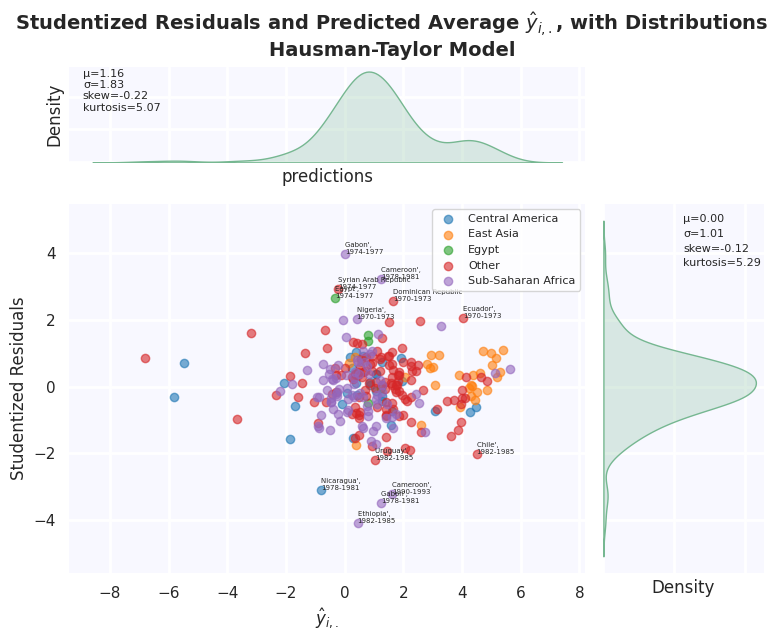

In [ ]:
resid_plot(x=lambda_weighted_demeaned, model=lambda_iv, title='Hausman-Taylor Model', transform='HT',
           color_col=region_dummies, labels_y=True, outlier_y=(-2,2))

In [ ]:
mundlak_results = mundlak_results[[x.find('mean') == -1 for x in mundlak_results.index]]
to_merge = [between_results, fe_results, fete_results, re_results, mundlak_results, iv_results, ht_results]
results = reduce(lambda left, right: pd.merge(left, right, how='outer', left_index=True, right_index=True), to_merge)
results.iloc[:12, :]

Between Fixed Effects Fixed/Time Effects  \
Assassinations            -0.170        -0.537           -0.654**   
Central America        -1.324***           NaN                NaN   
East Asia                  0.204           NaN                NaN   
Effective Aid              0.238        -0.123              0.142   
Egypt                   3.334***           NaN                NaN   
Ethnic Frac                  NaN           NaN                NaN   
Ethnic Pct                -0.014           NaN                NaN   
Ethnic x Assass            0.576       1.052**            1.262**   
Institutional Quality      0.231           NaN                NaN   
L_Money Supply             0.002       -0.042*              0.001   
Log GDP                    0.246     -4.069***             -2.173   
Policy                  1.656***      0.929***           0.840***   

                      Random Effects    Mundlak        IV        HT  
Assassinations             -0.455***  -0.657***   -0.495*  -0.591**  
Central America             -0.947**   -1.055**       NaN       NaN  
East Asia                      0.920      0.329       NaN       NaN  
Effective Aid                  0.113      0.117  -0.236**  -0.193**  
Egypt                       3.199***   3.223***       NaN       NaN  
Ethnic Frac                      NaN        NaN       NaN    -0.012  
Ethnic Pct                    -0.315        NaN       NaN       NaN  
Ethnic x Assass             0.919***   1.268***     0.643   1.096**  
Institutional Quality       0.591***    0.421**       NaN  0.485***  
L_Money Supply                -0.003     -0.004     0.009     0.008  
Log GDP                       -0.458     -2.283    -0.000  -0.228**  
Policy                      1.003***   0.818***  1.254***  1.168***

15.	*If one of your variable is time-invariant z(i) (Institutional quality ICRG for Burnside Dollar), run a between regression on z(i) explained by X(i.) and other time invariant variable (only with N observations). If the R2 is low, this may signal X(i.) are weak instruments poorly correlated with the variable z(i) to be instrumented. Comment.*


The R^2 is moderate at 0.332 for all of our time invariant variables and 0.198 for GDP growth. This tells us that some of the weak instruments have slight correlation with institutal quality. Curiously, Log GDP is very significant telling us that larger economies tend to have higher quality institutions.

In [ ]:
ols = sm.OLS(_df['Institutional Quality'].groupby('country').transform('mean'), sm.add_constant(between[to_instrument]), hasconst=True)
results = ols.fit(cov_type='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Institutional Quality   R-squared:                       0.332
Model:                               OLS   Adj. R-squared:                  0.317
Method:                    Least Squares   F-statistic:                     32.63
Date:                   Mon, 29 Jan 2024   Prob (F-statistic):           2.02e-29
Time:                           22:39:35   Log-Likelihood:                -392.69
No. Observations:                    275   AIC:                             799.4
Df Residuals:                        268   BIC:                             824.7
Df Model:                              6                                         
Covariance Type:                     HC0                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.3437      0.962     -1.397      0.163      -3.230       0.542
L_Money Supply     -0.0024      0.006     -0.386      0.699      -0.015       0.010
Policy              0.4095      0.070      5.818      0.000       0.272       0.547
Effective Aid       0.0642      0.049      1.307      0.191      -0.032       0.160
Assassinations     -0.4614      0.147     -3.143      0.002      -0.749      -0.174
Ethnic x Assass    -0.1503      0.287     -0.524      0.600      -0.712       0.412
Log GDP             0.7475      0.117      6.394      0.000       0.518       0.977
==============================================================================
Omnibus:                        0.226   Durbin-Watson:                   0.454
Prob(Omnibus):                  0.893   Jarque-Bera (JB):                0.273
Skew:                          -0.068   Prob(JB):                        0.872
Kurtosis:                       2.927   Cond. No.                         500.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [ ]:
sm.OLS(_df['Institutional Quality'].groupby('country').transform('mean'), sm.add_constant(between['GDP Growth']), has_const=True).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Institutional Quality   R-squared:                       0.198
Model:                               OLS   Adj. R-squared:                  0.195
Method:                    Least Squares   F-statistic:                     67.36
Date:                   Mon, 29 Jan 2024   Prob (F-statistic):           9.03e-15
Time:                           22:39:35   Log-Likelihood:                -417.78
No. Observations:                    275   AIC:                             839.6
Df Residuals:                        273   BIC:                             846.8
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2693      0.076     56.254      0.000       4.120       4.419
GDP Growth     0.2506      0.031      8.207      0.000       0.190       0.311
==============================================================================
Omnibus:                       53.087   Durbin-Watson:                   0.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.605
Skew:                          -0.212   Prob(JB):                      0.00111
Kurtosis:                       1.996   Cond. No.                         2.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

16.	*Time invariant variable used in interaction with a time varying variable. Generate a variable which is the product of ICRG (a governance-corruption indicator which is time-invariant) and foreign aid EDA/GDP. Include this product AND foreign aid into a one way fixed effects regression. Plot the estimated marginal effect (derivative) with respect to ICRG as a function of EDA/GDP (which is positive and goes as far as 20%).*


We find that higher levels of institutional quality magnify the positive effect of aid on GDP growth. Likewise, we find that low institutional quality dampens it.

In [ ]:
from statsmodels.formula.api import ols
df['IQxEffAid'] = df['Institutional Quality'] * df['Effective Aid']
model = ols('Q("Effective Aid") ~ Q("Institutional Quality") + IQxEffAid', data=df).fit()

df['marginal_effect'] = model.params['Q("Institutional Quality")'] + model.params['IQxEffAid']

results_table = model.summary2().tables[1]
results_table

Coef.  Std.Err.       t  P>|t|  [0.025  0.975]
Intercept                   1.610     0.122  13.185  0.000   1.370   1.851
Q("Institutional Quality") -0.312     0.026 -12.169  0.000  -0.363  -0.262
IQxEffAid                   0.203     0.003  62.646  0.000   0.197   0.209

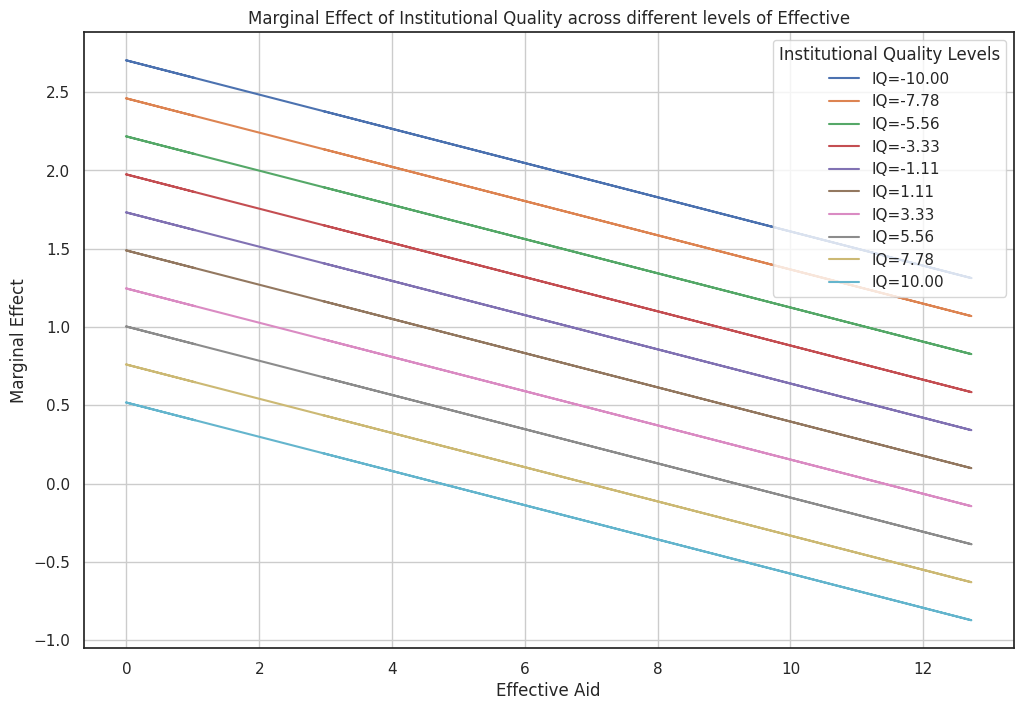

Coef.  Std.Err.       t  P>|t|  [0.025  0.975]
Intercept                   1.610     0.122  13.185  0.000   1.370   1.851
Q("Institutional Quality") -0.312     0.026 -12.169  0.000  -0.363  -0.262
IQxEffAid                   0.203     0.003  62.646  0.000   0.197   0.209

In [ ]:
from statsmodels.formula.api import ols

df['IQxEffAid'] = df['Institutional Quality'] * df['Effective Aid']

model = ols('Q("Effective Aid") ~ Q("Institutional Quality") + IQxEffAid', data=df).fit()

df['marginal_effect'] = model.params['Q("Institutional Quality")'] + model.params['IQxEffAid']

iq_levels = np.linspace(-10,10,num=10)

plt.figure(figsize=(12, 8))

for iq in iq_levels:
  df['marginal_effect_iq'] = df['marginal_effect'] * (df['Effective Aid']
  + iq)  + model.params['Intercept']
  plt.plot(df['Effective Aid'], df['marginal_effect_iq'], label=f'IQ={iq:.2f}')

plt.title('Marginal Effect of Institutional Quality across different levels of Effective')
plt.xlabel('Effective Aid')
plt.ylabel('Marginal Effect')
plt.legend(title="Institutional Quality Levels")
plt.grid(True)
plt.show()
results_table = model.summary2().tables[1]
results_table

17.	Anderson-Hsiao (1981) estimator for dynamic panel data adding a lag of the foreign aid/GDP (adding lags of other control variables is optional):
Δ GDPGi,t = βy Δ GDPGi,t-1 + β1 Δ (aid/GDP)i,t + β2 Δ (aid/GDP)i,t-1 + Δ Controls i,t + Δ αi + Δ αt + Δ εi

> 1. *For all these variables: ΔGDPGi,t  Δ GDPGi,t-1 Δ (aid/GDP)i,t  Δ(aid/GDP)i,t-1  GDPGi,t-2  (aid/GDP)i,t-2 report univariate statistics (mean median standard error,  skewness, kurtosis, min max) and comment.*




In [ ]:
df = df.reset_index(level=0)

In [ ]:
df = df.drop(columns=['year1'])

In [ ]:
df = df.reset_index()

In [ ]:
if df['year1'].dtype != 'O':
  df['year1'] = df['year1'].astype(str)

df['year1'] = df['year1'].str.split('-').str[0].astype(int)

df.set_index(['country', 'year1'], inplace=True)

df['aid_GDP'] = df['Effective Aid'] / df['gdp']

df['Delta_GDPG'] = df['GDP Growth'].groupby(level=0).diff()
df['Delta_aid_GDP'] = df['aid_GDP'].groupby(level=0).diff()

df['Lag1_Delta_GDPG'] = df['Delta_GDPG'].groupby(level=0).shift()

df['Lag1_Delta_aid_GDP'] = df['Delta_aid_GDP'].groupby(level=0).shift()
df['GDPG_Lag2'] = df['GDP Growth'].groupby(level=0).shift(2)
df['aid_GDP_Lag2'] = df['aid_GDP'].groupby(level=0).shift(2)

vars_of_interest = ['Delta_GDPG', 'Lag1_Delta_GDPG', 'Delta_aid_GDP', 'Lag1_Delta_aid_GDP', 'GDPG_Lag2', 'aid_GDP_Lag2']
univariate_stats = df[vars_of_interest].agg(['mean', 'median', 'std', 'skew', 'kurt', 'min', 'max'])

print("Univariate Statistics:\n", univariate_stats)

Univariate Statistics:
         Delta_GDPG  Lag1_Delta_GDPG  Delta_aid_GDP  Lag1_Delta_aid_GDP  \
mean        -0.334           -0.644          0.000               0.000   
median       0.046           -0.090          0.000               0.000   
std          4.157            4.303          0.001               0.001   
skew        -0.643           -0.914          3.439               3.340   
kurt         3.696            3.230         17.766              16.003   
min        -21.806          -21.806         -0.003              -0.002   
max         14.935            9.504          0.009               0.006   

        GDPG_Lag2  aid_GDP_Lag2  
mean        1.513         0.001  
median      1.695         0.000  
std         3.725         0.002  
skew       -0.108         2.706  
kurt        0.707         8.213  
min       -10.261         0.000  
max        12.270         0.009  


 > 2. *Report the bivariate simple correlation coefficients matrix. The correlation between Δ GDPGi,t-1 Δ (aid/GDP)i,t  Δ (aid/GDP)i,t-1  and the instruments in levels: GDPGi,t-2  (aid/GDP)i,t-2 is a preliminary check for the strength of these instruments.*

The strongest correlations are between aid_GDP_Lag2 with both Delta_aid_GDP and Lag1_Delta_aid_GDP. That makes sense because aid between time periods is highly correlated.

The strongest negative relationship is between GDPG_Lag2 and Lag1_Delta_GDPG. I believe that is due to GDP growth featuring a reversion to the mean between periods.

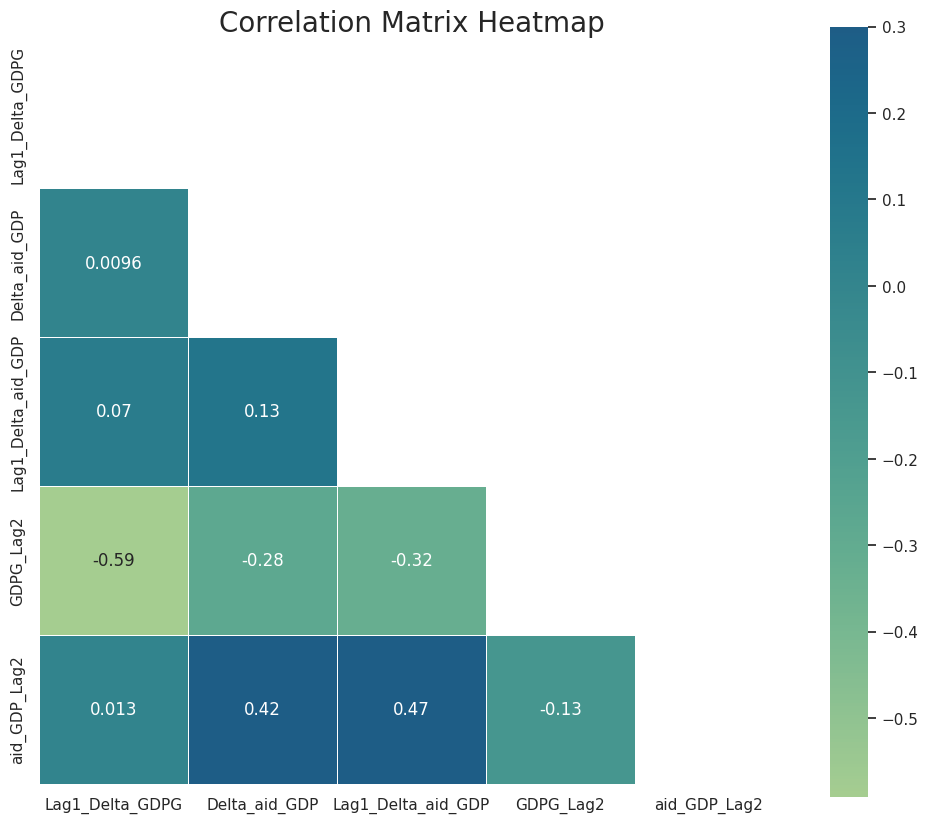

In [ ]:
df['aid_GDP'] = df['Effective Aid'] / df['gdp']

df['Delta_GDPG'] = df.groupby(level=0)['GDP Growth'].diff()
df['Delta_aid_GDP'] = df.groupby(level=0)['aid_GDP'].diff()

df['Lag1_Delta_GDPG'] = df['Delta_GDPG'].groupby(level=0).shift()
df['Lag1_Delta_aid_GDP'] = df['Delta_aid_GDP'].groupby(level=0).shift()
df['GDPG_Lag2'] = df['GDP Growth'].groupby(level=0).shift(2)
df['aid_GDP_Lag2'] = df['aid_GDP'].groupby(level=0).shift(2)

vars_for_correlation = ['Lag1_Delta_GDPG', 'Delta_aid_GDP', 'Lag1_Delta_aid_GDP', 'GDPG_Lag2', 'aid_GDP_Lag2']

correlation_matrix = df[vars_for_correlation].corr()

sns.set(style="white")

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, mask=mask, cmap='crest', vmax=.3, center=0, square=True, linewidths=.5, annot=True)

plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.show()

> 3. *Do a panel data unit root test of your choice on the variables ΔGDPGi,t and  Δ(aid/GDP)i,t and comment.*

Panel data unit root tests are not possible in Python. Running an ADF test for each country in our panel, we see that many have a unit-root. This is not surprising, GDP Growth and Aid are highly correlated throughout time. A shock in one time period do not effect future Aid since that is a flow and not a stock variable.

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

df.reset_index(inplace=True)
df

df['country'] = df['country'].astype('category')
df['year1'] = pd.to_datetime(df['year1'], format="%Y")

from statsmodels.tsa.stattools import adfuller
import numpy as np

def adf_test(series, country):

  if len(series) < 3:
    print(f"Not enough data for {country}. Only {len(series)} observations available after cleaning.")
    return

  print(f'{country}:')
  try:
    result = adfuller(series, autolag='AIC')
    print(f'p-value: {result[1]}')
  except ValueError as e:
        print(f"Cannot perform ADF test for {country} due to: {e}")

for country in df['country'].unique():
  data_country = df[df['country'] == country]
  series = data_country['Delta_GDPG'].replace([np.inf, -np.inf], np.nan).dropna()
  adf_test(series, country)

Not enough data for Algeria. Only 1 observations available after cleaning.
Argentina:
p-value: 0.9896632555275383
Bolivia:
p-value: 0.6612431492644019
Not enough data for Botswana. Only 2 observations available after cleaning.
Brazil:
p-value: 0.4984009368776566
Cameroon:
p-value: 2.0511143947715564e-12
Chile:
p-value: 6.458246198289659e-05
Colombia:
p-value: 0.00034262451888761287
Costa Rica:
p-value: 0.7109664273287158
Not enough data for Cote D'Ivoire. Only 0 observations available after cleaning.
Dominican Republic:
p-value: 0.062436317146703744
Ecuador:
p-value: 0.49012516220523084
Egypt:
p-value: 0.1319033316843226
El Salvador:
p-value: 0.3466821863778109
Not enough data for Ethiopia. Only 1 observations available after cleaning.
Gabon:
p-value: 0.012443485598549789
Gambia, The:
p-value: 2.2832058781142008e-21
Ghana:
p-value: 1.1024752410616579e-08
Guatemala:
p-value: 0.48339107364069006
Guyana:
p-value: 0.8022163725488235
Haiti:
p-value: 0.4074372916574211
Honduras:
p-value: 0.3

 > 4. *Report the OLS including the lag of the first difference of GDPG and of other explanatory variables. Report the number of observations and the number of countries remaining in the estimation, which requires at least three consecutive observations for each country.*

There are 166 observations across 48 countries. The only significant variable is 'Lag1_Delta_GDPG' with a p-value of 0.00. This makes sense theoretically: we know that GDP growth tends to feature a reversion to the mean.

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

df['Lag1_Delta_GDPG'] = df.groupby('country')['Delta_GDPG'].shift(1)

df['Lag1_Delta_aid_GDP'] = df.groupby('country')['Delta_aid_GDP'].shift(1)

count_obs = df.groupby('country').size()
valid_countries = count_obs[count_obs >= 3].index
df = df[df['country'].isin(valid_countries)]

Y = df['Delta_GDPG']

X = df[['Lag1_Delta_GDPG', 'Lag1_Delta_aid_GDP']]
X = sm.add_constant(X)

model = sm.OLS(Y, X, missing='drop').fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Delta_GDPG   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     21.46
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           5.32e-09
Time:                        22:35:40   Log-Likelihood:                -455.87
No. Observations:                 166   AIC:                             917.7
Df Residuals:                     163   BIC:                             927.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.8665      0

In [ ]:
count_obs
valid_countries.nunique()

48

 > 5. *Report the IV estimator (IVREG) when you use the instruments in levels GDPGi,t-2  and (aid/GDP)i,t-2 . Comment how much each parameter changes when using OLS versus IV.*

The IV2SLS regression had coefficients whose p-values were all greater than 0.75. The confidence intervals ranged from a strong positive to a strong negative relationship for each coefficient. This tells us that it is largely useless for modelling our data.

The OLS regression did not fare much better. Delta_aid_GDP and Lag1_Delta_aid_GDP both have coefficients over 400, while the rest are near zero. It does not make sense that these are overwhelmingly the determinant in GDP growth, implying that there is omitted variable bias.

In [ ]:
df['log GDP'] = np.log(df['gdp'])

In [ ]:
df2 = df.dropna(subset=["Lag1_Delta_GDPG","Delta_aid_GDP","Lag1_Delta_aid_GDP" ,'Budget Surplus', 'Trade Openness', "govc",'GDPG_Lag2', 'aid_GDP_Lag2'])

In [ ]:
for col in ["Lag1_Delta_GDPG","Delta_aid_GDP","Lag1_Delta_aid_GDP" ,'Budget Surplus', 'Trade Openness', "govc",'GDPG_Lag2', 'aid_GDP_Lag2']:
  print(f"{col} NaN count: {df2[col].isna().sum()}")
  print(f"{col} Inf count: {(np.isinf(df2[col])).sum()}")

Lag1_Delta_GDPG NaN count: 0
Lag1_Delta_GDPG Inf count: 0
Delta_aid_GDP NaN count: 0
Delta_aid_GDP Inf count: 0
Lag1_Delta_aid_GDP NaN count: 0
Lag1_Delta_aid_GDP Inf count: 0
Budget Surplus NaN count: 0
Budget Surplus Inf count: 0
Trade Openness NaN count: 0
Trade Openness Inf count: 0
govc NaN count: 0
govc Inf count: 0
GDPG_Lag2 NaN count: 0
GDPG_Lag2 Inf count: 0
aid_GDP_Lag2 NaN count: 0
aid_GDP_Lag2 Inf count: 0


In [ ]:
from statsmodels.sandbox.regression.gmm import IV2SLS

endog = df2['Delta_GDPG']
exog = sm.add_constant(df2[["Lag1_Delta_GDPG","Delta_aid_GDP","Lag1_Delta_aid_GDP" ,'Budget Surplus', 'Trade Openness', "govc"]])
instrument = df2[["Lag1_Delta_GDPG","Delta_aid_GDP","Lag1_Delta_aid_GDP" ,'Budget Surplus', 'Trade Openness', "govc", 'GDPG_Lag2', 'aid_GDP_Lag2']]

try:
  iv_model = IV2SLS(endog, exog, instrument).fit()
  print("IV Regression Results")
  print(iv_model.summary())
except Exception as e:
  print(f"Error in IV regression: {e}")

IV Regression Results
                          IV2SLS Regression Results                           
Dep. Variable:             Delta_GDPG   R-squared:                      -3.539
Model:                         IV2SLS   Adj. R-squared:                 -3.714
Method:                     Two Stage   F-statistic:                     3.154
                        Least Squares   Prob (F-statistic):            0.00602
Date:                Mon, 29 Jan 2024                                         
Time:                        22:35:41                                         
No. Observations:                 163                                         
Df Residuals:                     156                                         
Df Model:                           6                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const         

In [ ]:
endog = df2['Delta_GDPG']

exog = sm.add_constant(df2[["Lag1_Delta_GDPG","Delta_aid_GDP","Lag1_Delta_aid_GDP" ,'Budget Surplus', 'Trade Openness', "govc"]])
ols_model = sm.OLS(endog, exog, missing='drop').fit()

print("OLS Regression Results")
print(ols_model.summary())

OLS Regression Results
                            OLS Regression Results                            
Dep. Variable:             Delta_GDPG   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     14.04
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           9.54e-13
Time:                        22:35:41   Log-Likelihood:                -431.90
No. Observations:                 163   AIC:                             877.8
Df Residuals:                     156   BIC:                             899.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const        

 > 6. *Report the first stage regressions. Comment the R2 of each of the first stage regressions, if below 10%, it is a signal of weak instrument. You may comment statistics available in your software for weak instruments and for testing endogeneity of instruments.*

Running the first stage regression, we see that the R^2 is only 0.010. Both of our coefficients have a p-value grater that 0.10. That tells us that we have weak instruments and we are unable to draw conclusions about describing the data with OLS since the fit is so weak.

In [ ]:
instruments_exog = sm.add_constant(df[['GDPG_Lag2', 'aid_GDP_Lag2']])

dep_variable = df['Delta_GDPG']

first_stage = sm.OLS(dep_variable, instruments_exog, missing='drop').fit()

print("First Stage Regression Results")
print(first_stage.summary())

First Stage Regression Results
                            OLS Regression Results                            
Dep. Variable:             Delta_GDPG   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8496
Date:                Mon, 29 Jan 2024   Prob (F-statistic):              0.429
Time:                        22:35:41   Log-Likelihood:                -474.42
No. Observations:                 166   AIC:                             954.8
Df Residuals:                     163   BIC:                             964.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -

 > 7. *Compute and plot the impulse response functions for the next four periods for 1 unit increase of aid/GDP on GDPG:*

A 1 unit increase in aid, as a percent of GDP, initially has a positive effect on GDP Growth. The following period, it is negative, then positive again, and then negative. It oscillates over the first four periods. This is because $\beta_2$ and $\beta_y$ both have negative signs. With $\mid \beta_y \mid < 1$, the effect shrinks each period.

In [ ]:
df['Lag1_Delta_GDPG'] = df.groupby('country')['Delta_GDPG'].shift(1)
df['Lag1_Delta_aid_GDP'] = df.groupby('country')['aid_GDP'].shift(1)

Y = df['Delta_GDPG']
X = sm.add_constant(df[['aid_GDP', 'Lag1_Delta_aid_GDP', 'Lag1_Delta_GDPG']])
model = sm.OLS(Y, X, missing='drop').fit()

beta1 = model.params['aid_GDP']
beta2 = model.params['Lag1_Delta_aid_GDP']
betay = model.params['Lag1_Delta_GDPG']

print("Estimated coefficients:")
print("Beta1 (aid_GDP):", beta1)
print("Beta2 (Lag1_Delta_aid_GDP):", beta2)
print("Betay (Lag1_Delta_GDPG):", betay)

Estimated coefficients:
Beta1 (aid_GDP): 333.48223634364155
Beta2 (Lag1_Delta_aid_GDP): -320.9928765159789
Betay (Lag1_Delta_GDPG): -0.4404854172014163


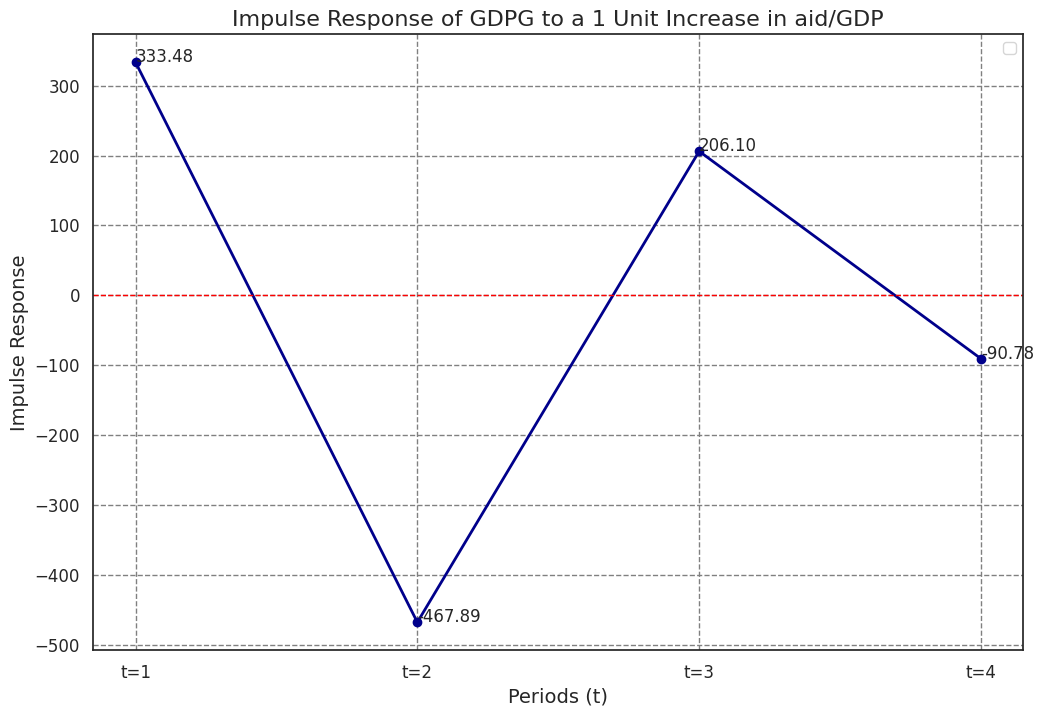

In [ ]:
beta1 = 333.48223634364155
beta2 = -320.9928765159789
betay = -0.4404854172014163

irf_t1 = beta1
irf_t2 = betay * beta1 + beta2
irf_t3 = betay**2 * beta1 + betay * beta2
irf_t4 = betay**3 * beta1 + betay**2 * beta2

irfs = [irf_t1, irf_t2, irf_t3, irf_t4]

periods = [1, 2, 3, 4]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(periods, irfs, marker='o', linestyle='-', color='darkblue', linewidth=2)

ax.set_title('Impulse Response of GDPG to a 1 Unit Increase in aid/GDP', fontsize=16)
ax.set_xlabel('Periods (t)', fontsize=14)
ax.set_ylabel('Impulse Response', fontsize=14)

ax.grid(True, linestyle='--', color='gray')

for i, txt in enumerate(irfs):
  ax.annotate(f"{txt:.2f}", (periods[i], irfs[i]))

ax.set_xticks(periods)
ax.set_xticklabels([f"t={i}" for i in periods], fontsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.axhline(0, color='red', linewidth=1, linestyle='--')

ax.legend()

plt.show()

> 8. *Compute the long run coefficient of aid/GDP on GDPG and comment:*
$$\beta_{LT} = \frac{\beta_1+\beta_2}{1- \beta_y}$$

Our long-term coefficient $\beta_{LT}$ is 8.670. This tells us that an increase in aid, as a percent of GDP, has a positive long-term relationship with GDP growth.

In [ ]:
beta1 = 333.48223634364155
beta2 = -320.9928765159789
betay = -0.4404854172014163

if 1 - betay != 0:
  beta_LT = (beta1 + beta2) / (1 - betay)
  print("Long-Run Coefficient (Beta_LT):", beta_LT)
else:
  print("error")

Long-Run Coefficient (Beta_LT): 8.670243848720851


18. *Propose an interesting estimation using the database.*


We would like to propose a variation where we relate gdp growth to the sum or previous aid and the current period's effective aid. The theory being, does aid in previous periods add up to greater future growth - or does it hinder it? Does aid in the current period benefit that period or does it slow growth? With the simple correlation coefficient on growth being negative from aid, adding past aid as a factor helps us understand the longterm effects of aid on growth.

A problem with our dataset is that it is incomplete panel data. This assumes that there was no aid in missing periods. Obviously that is not a sensible assumption to make however for the sake of implementation we are overlooking that. Another issue is that past aid is highly correlated with the current period's aid.

Our results found that previous and current aid both had a negative coefficient. However, the confidence interval for the current period was wide and included the possiblity of a positive relationship. When constructing the same OLS with current and previous aid multiplied by the policy index, we see a strong positive relationship for the current period's aid and a slight negative relationship for past aid.

This leads us to conclude that aid is beneficial or benign in the period when it is given. However, aid has a negative effect of GDP growth in future periods. This is an interesting extension of the rest of this project because it explores how aid functions over time treating aid as a stock instead of a flow variable.



In [ ]:
a = _df['Effective Aid'].groupby(['country', 'year']).sum().groupby(level=0).cumsum().reset_index()

In [ ]:
a = a.reset_index(allow_duplicates=True).set_index(['country', 'year']).iloc[:,-1:]

In [ ]:
_df['Cum Effective Aid'] = a

In [ ]:
_df['Pre Effective Aid'] = _df['Cum Effective Aid'] - _df['Effective Aid']

In [ ]:
_df['Pre x Policy'] = _df['Pre Effective Aid'] * _df['Policy']

In [ ]:
_df['EA x Policy'] = _df['Effective Aid'] * _df['Policy']

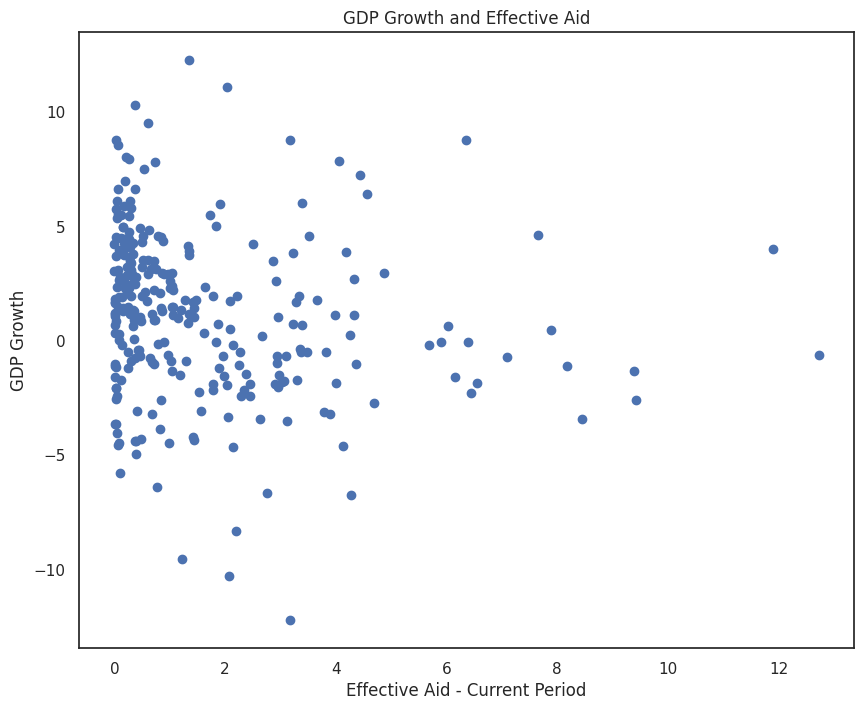

In [ ]:
# Simple Scatterplot
#x1 = _df['Pre Effective Aid']
x2 = _df['Effective Aid']
y = _df['GDP Growth']
#plt.scatter(x1, y)
plt.scatter(x2, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('GDP Growth and Effective Aid')
plt.xlabel('Effective Aid - Current Period')
plt.ylabel('GDP Growth')
plt.show()

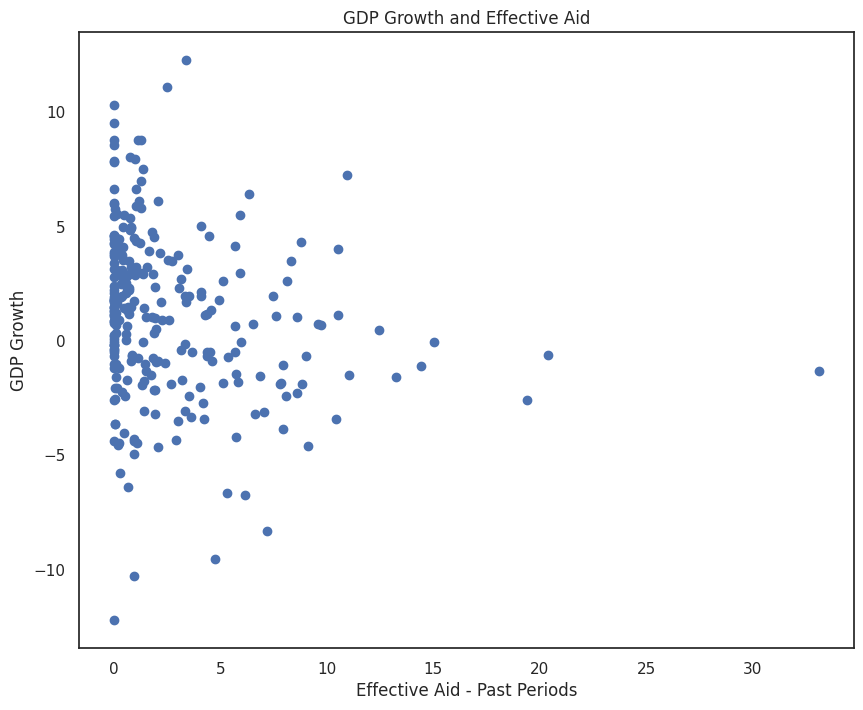

In [ ]:
# Simple Scatterplot
x1 = _df['Pre Effective Aid']
#x2 = _df['Effective Aid']
y = _df['GDP Growth']
plt.scatter(x1, y)
#plt.scatter(x2, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('GDP Growth and Effective Aid')
plt.xlabel('Effective Aid - Past Periods')
plt.ylabel('GDP Growth')
plt.show()

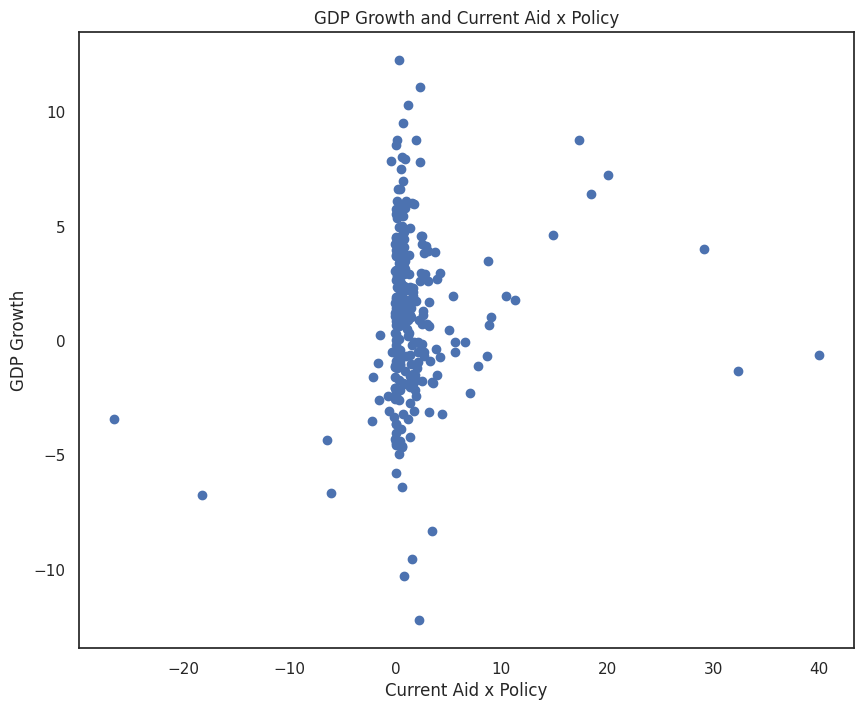

In [ ]:
# Simple Scatterplot
#x1 = _df['Pre x Policy']
x2 = _df['EA x Policy']
y = _df['GDP Growth']
#plt.scatter(x1, y)
plt.scatter(x2, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('GDP Growth and Current Aid x Policy')
plt.xlabel('Current Aid x Policy')
plt.ylabel('GDP Growth')
plt.show()

In [ ]:
# Simple Scatterplot
x1 = _df['Pre x Policy']
#x2 = _df['EA x Policy']
y = _df['GDP Growth']
plt.scatter(x1, y)
#plt.scatter(x2, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('GDP Growth and Past Aid x Policy')
plt.xlabel('Past Aid x Policy')
plt.ylabel('GDP Growth')
plt.show()

In [ ]:
_df[['GDP Growth','Pre Effective Aid','Effective Aid','Pre x Policy','EA x Policy']].corr()

GDP Growth  Pre Effective Aid  Effective Aid  Pre x Policy  \
GDP Growth              1.000             -0.207         -0.173         0.059   
Pre Effective Aid      -0.207              1.000          0.712         0.656   
Effective Aid          -0.173              0.712          1.000         0.389   
Pre x Policy            0.059              0.656          0.389         1.000   
EA x Policy             0.128              0.469          0.514         0.841   

                   EA x Policy  
GDP Growth               0.128  
Pre Effective Aid        0.469  
Effective Aid            0.514  
Pre x Policy             0.841  
EA x Policy              1.000

In [ ]:
Y = _df['GDP Growth']
X = sm.add_constant(_df[['Pre x Policy','EA x Policy']])
model = sm.OLS(Y, X, missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             GDP Growth   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.456
Date:                Mon, 29 Jan 2024   Prob (F-statistic):             0.0330
Time:                        22:35:43   Log-Likelihood:                -738.43
No. Observations:                 275   AIC:                             1483.
Df Residuals:                     272   BIC:                             1494.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0358      0.227      4.564      0.000       0.589       1.483
Pre x Policy    -0.0611      0.040     -1.520      0.130      -0.140       0.018
EA x Policy      0.1996      0.082      2.439      0.015       0.038       0.361
==============================================================================
Omnibus:                        7.724   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               11.907
Skew:                          -0.134   Prob(JB):                      0.00260
Kurtosis:                       3.984   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Y = _df['GDP Growth']
X = sm.add_constant(_df[['Pre Effective Aid', 'Effective Aid']])
model = sm.OLS(Y, X, missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             GDP Growth   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     6.317
Date:                Mon, 29 Jan 2024   Prob (F-statistic):            0.00208
Time:                        22:35:43   Log-Likelihood:                -735.64
No. Observations:                 275   AIC:                             1477.
Df Residuals:                     272   BIC:                             1488.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7234      0.273      6.323      0.000       1.187       2.260
Pre Effective Aid    -0.1589      0.079     -2.018      0.045      -0.314      -0.004
Effective Aid        -0.0908      0.147     -0.619      0.537      -0.380       0.198
==============================================================================
Omnibus:                       10.397   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.468
Skew:                          -0.194   Prob(JB):                     0.000161
Kurtosis:                       4.172   Cond. No.                         6.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

19. *Download GDP growth and foreign aid ODA/GDP from World Bank and/or IMF and/or FRED databases with the largest coverage of years and countries. Compute first differences in panel for both variables. Report the simple correlation coefficient with its number of observations. Is it similar to the one found in question 16.2?*


We are utilizing the official development assistance (ODA) and GDP growth indicators from the World Bank (World Bank 2024). There are 4,346 observations - that is country and year combinations that include both ODA and GDP growth. After calculating first differences we find a correlation coefficient of -0.0343. A heat map shows that there is a distribution about
the origin.


This is similar to the slight negative correlation we found between GDP growth and foreign aid.

In [ ]:
url = 'https://raw.githubusercontent.com/andrewpwalters/panel_data/main/worldbank.csv'
df = pd.read_csv(url)

In [ ]:
oda = df[df['Series Code'] == 'DT.ODA.ODAT.MP.ZS']
oda = oda.iloc[:, 3:]
for col in oda.columns:
  oda = oda.rename(columns={col: col[6:-1]})
oda.rename(columns={'y Cod': 'Country Code'}, inplace=True)
oda = pd.wide_to_long(oda, 'YR', i='Country Code', j='Year')
oda.rename(columns={'YR': 'ODA'}, inplace=True)

In [ ]:
gdpg = df[df['Series Code'] == 'NY.GDP.MKTP.KD.ZG']
gdpg = gdpg.iloc[:, 3:]
for col in gdpg.columns:
  gdpg = gdpg.rename(columns={col: col[6:-1]})
gdpg.rename(columns={'y Cod': 'Country Code'}, inplace=True)
gdpg = pd.wide_to_long(gdpg, 'YR', i='Country Code', j='Year')
gdpg.rename(columns={'YR': 'GDPG'}, inplace=True)


In [ ]:
oda = oda.merge(gdpg, how='inner', on=['Year', 'Country Code'], validate='one_to_one')

In [ ]:
oda = oda.replace('..', None)
oda = oda.apply(pd.to_numeric)

In [ ]:
oda = oda.diff()

In [ ]:
nonnull = oda.dropna()
nonnull.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4346 entries, (1974, 'HND') to (2021, 'WLD')
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ODA     4346 non-null   float64
 1   GDPG    4346 non-null   float64
dtypes: float64(2)
memory usage: 93.5+ KB


In [ ]:
print(oda['ODA'].corr(oda['GDPG']))


-0.03431880347609868


In [ ]:
x = oda['ODA']
y = oda['GDPG']

sns.set_theme()

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

plt.show()


20. *Optional: mention or propose improvements to the Python, STATA, SAS or R code (copy it here). Optional: propose improvements, additional insights, and you do not know how to code them.*


Our code could be improved by including only countries where there is complete panel data available. The data imbalances may be due to common causes (political instability for example) that correlate with our explanatory variable. While excluding them would include the same error, perhaps we could find a different subset that has complete panel data. For example, states that were independent prior to the Second World War are mostly complete.


We also could create a DSGE model to show the pass through from foreign aid to GDP, with institutional effectiveness and other factors used to influence the pass-through.

An issue I have with Burnside & Dollar's paper is that the policy index heavily weighs inflation. This is a problem because inflation is an outcome of policy, it is not policy unto itself. Thus the policy index has a reverse causality problem that carries out into the rest of their application of it.

#Bibliography

 - Burnside & Dollar (2000) ’Aid, Policies, and Growth.’, The American Economic Review, Vol. 90, No. 4 (Sep., 2000), pp. 847-868. https://www.jstor.org/stable/117311


- Grabowski, J. (2020) ’Replication of Burnside and Dollar (2000).’ http://jbgrabowski.com/notebooks/panel-data/


- World Bank (2024) ’World Development Indicators: NY.GDP.MKTP.KD.ZG and
DT.ODA.ODAT.MP.ZS.’ https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG